For the paper:
- Use https://arxiv.org/abs/1706.06103 for scattering
- Use term "optical depth" instead of lensing fraction, check that out
- Update parameters with https://arxiv.org/pdf/2208.00819.pdf
- Scattering in lens: 
    - https://arxiv.org/pdf/1706.06103.pdf
    - https://iopscience.iop.org/article/10.1088/0004-637X/776/2/125/pdf
- Compare rates to https://arxiv.org/pdf/2206.14310.pdf


TODO
- Update parameters with Clancy model
- Use "rate interpretation" of alpha (https://arxiv.org/pdf/2101.08005.pdfhttps://arxiv.org/pdf/2101.08005.pdf)
- Add other telescopes
- Add uncertainties
- Add magnification factor
- Add scattering horizon
- Same number of FRBs for lensed simulations
- Revise total rate for multi-band searches
- Try FoV at middle of the band

In [1]:
import warnings
warnings.filterwarnings("error")

In [1]:
import sys
sys.path.insert(0, "/arc/home/michilli/.local/lib/python3.8/site-packages/")
sys.path.append("/arc/home/michilli/CHIMEFRB-Cat1-Energy-Dist-Distrs/")

In [491]:
# Python 3.8.16
import os
import pickle
import datetime
import itertools

# Numpy 1.24.2
import numpy as np
from numpy.random import default_rng
# matplotlib 3.7.1
import matplotlib.pyplot as plt
# astropy 5.2.1
from astropy import units as u
from astropy.coordinates import Distance
from astropy import constants as const
from astropy.cosmology import Planck18 as cosmo
# scipy 1.9.3
from scipy.special import j1
from scipy import optimize
from scipy.stats import truncnorm
from scipy.ndimage import gaussian_filter as gf
from scipy.interpolate import CubicSpline as spline
from scipy import integrate
# mpmath 1.3.0
from mpmath import gammainc
# pandas 2.0.0
import pandas as pd


# Classes and functions

class Telescope:
    """
    Telescope parameters
    """
    parameters = {
        'dummy': {  # test parameters
            'Srec': 15 * u.Jy,
            'v0': 800 * u.MHz,
            'v1': 1600 * u.MHz,
            'D': 50 * u.m,
            'bands': [
                [800 * u.MHz, 1200 * u.MHz],
                [1200 * u.MHz, 1600 * u.MHz],
            ]
        },
        'chime': {  # from https://ui.adsabs.harvard.edu/abs/2022ApJS..261...29C/abstract
            # from https://ui.adsabs.harvard.edu/abs/2017ApJ...844..140C/abstract
            'Srec': 50 / 1.38 * u.Jy,
            'gain': 1.38 * u.K / u.Jy,
            'v0': 400 * u.MHz,
            'v1': 800 * u.MHz,            
            'Dx': 20 * u.m,
            'Dy': 0.87 * u.m,  # Emprirical value to have a beam of ~100 deg
        },
        'utmost': {  # from https://arxiv.org/pdf/1708.09619.pdf
            'Srec': 115 * np.sqrt(2) * u.Jy,  # The sqrt(2) correction is for the single polarization
            'gain': 0.5 * u.K / u.Jy,
            'v0': 836 * u.MHz,
            'v1': 850 * u.MHz,            
            'Dx': 11.6 * u.m,
            'Dy': 0.88 * (835 * u.MHz).to(u.m, equivalencies=u.spectral()) / (4.25 * u.deg).to(u.rad).value,  # Value to have a FWHP=4.25deg
        },
        'chord': {  # from https://ui.adsabs.harvard.edu/abs/2019clrp.2020...28V/abstract
            'Srec': 9 * u.Jy,
            'gain': 30 / 9 * u.K / u.Jy,
            'v0': 300 * u.MHz,
            'v1': 1500 * u.MHz,
            'D': 6 * u.m,
            'bands': [
                [300 * u.MHz, 700 * u.MHz],
                [700 * u.MHz, 1100 * u.MHz],
                [1100 * u.MHz, 1500 * u.MHz],
            ]
        },
        'dsa2000': {  # from https://ui.adsabs.harvard.edu/abs/2019BAAS...51g.255H/abstract
            'Srec': 2.5 * u.Jy,
            'gain': 25 / 2.5 * u.K / u.Jy,
            'v0': 700 * u.MHz,
            'v1': 2000 * u.MHz,
            'D': 5 * u.m,
            'bands': [
                [700 * u.MHz, 1100 * u.MHz],
                [1100 * u.MHz, 1500 * u.MHz],
                [1500 * u.MHz, 2000 * u.MHz],
            ]
        },
        'aperitif': {  # from https://ui.adsabs.harvard.edu/abs/2022A%26A...658A.146V/abstract
            'Srec': 560 * u.Jy,
            'gain': 70 / 560 * u.K / u.Jy,
            'v0': (1370 - 300/2) * u.MHz,
            'v1': (1370 + 300/2) * u.MHz,            
            'D': 25 * u.m,
        },
        'fast': {  # from https://ui.adsabs.harvard.edu/abs/2016RaSc...51.1060L/abstract
            'Srec': 20 * u.K / (18 * u.K / u.Jy),
            'gain': 18 * u.K / u.Jy,
            'v0': 1220 * u.MHz,
            'v1': 1520 * u.MHz,            
            'D': 300 * u.m,
        },
        'askap': {  # from https://ui.adsabs.harvard.edu/abs/2016PASA...33...42M/abstract
            'Srec': 2000 * u.Jy,
            'gain': 115 / 4000 * u.K / u.Jy,
            'v0': (1320 - 336/2) * u.MHz,
            'v1': (1320 + 336/2) * u.MHz,            
            'D': 12 * u.m,
        },
        'parkes': {  # from https://ui.adsabs.harvard.edu/abs/2001MNRAS.328...17M/abstract
            'Srec': 21 / 0.7 * u.Jy,
            'gain': 0.7 * u.K / u.Jy,
            'v0': (1374 - 288/2) * u.MHz,
            'v1': (1374 + 288/2) * u.MHz,            
            'D': 64 * u.m,
        },
        'parkes': {  # from https://ui.adsabs.harvard.edu/abs/2001MNRAS.328...17M/abstract
            'Srec': 21 / 0.7 * u.Jy,
            'gain': 0.7 * u.K / u.Jy,
            'v0': (1374 - 288/2) * u.MHz,
            'v1': (1374 + 288/2) * u.MHz,            
            'D': 64 * u.m,
        },
        'gbt': {  # from https://www.gb.nrao.edu/scienceDocs/GBTpg.pdf
            'Srec': 20 * u.Jy,
            'gain': 2 * u.K / u.Jy,
            'v0': 1150 * u.MHz,
            'v1': 1730 * u.MHz,            
            'D': 100 * u.m,
        },
    }
    
    def __init__(self, name='chord'):
        self.name = name
        self.parameters = Telescope.parameters
        try:
            _ = self.parameters[name]
        except KeyError:
            raise NotImplemented("Telescope unknown.")
        
    def get_parameters(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]
    
    def bandwidth(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v1'] - self.parameters[name]['v0']
    
    def sefd(self, name = None, freq = None, uncertain = False):
        if name is None: name = self.name
        if freq is None:
            freq = (
                self.parameters[name]['v0'] + 
                self.parameters[name]['v1']
            ) / 2
        sefd = (
            self.parameters[name]['Srec'] + 
            34 * u.K * (freq / 408 / u.MHz)**-2.6 / 
            self.parameters[name]['gain']
        )
        if uncertain:
            # Add an error of 20%
            sefd = rng.normal(
                loc=sefd.to(u.Jy).value,
                scale=sefd.to(u.Jy).value * 0.2
            ) * u.Jy
        return sefd
    
    def v0(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v0']
    
    def v1(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v1']
    
    def frequency_bands(self, name = None):
        if name is None: name = self.name
        try:
            return self.parameters[name]['bands']
        except KeyError:
            return [[
                self.parameters[name]['v0'],
                self.parameters[name]['v1']
            ]]
    
    def get_parameter(self, parameter, name = None):
        if name is None: name = self.name
        return self.parameters[name][parameter]

    
class FRB_Population:
    """
    Parameters of the FRB population.
    """
    parameters = {
        'shin': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': 2.38e41 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': -1.39,  # Spectral index
            'alpha_rate': 0,  # Rate index
            'gamma': -1.3,  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': 7.3e4 / u.Gpc**3 / u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': 0.96,  # Index of star-formation rate
        },
        'shin_rate_interpretation': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': 1.95e41 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': -1.10,  # Spectral index
            'gamma': -1.3,  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': 6.8e4 / u.Gpc**3 / u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': 1.72,  # Index of star-formation rate
        },
        'james2023': {  # From https://arxiv.org/pdf/2208.00819.pdf
            'Echar': 10**41.26 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': -0.99,  # Spectral index
            'gamma': -0.95-1,  # Differential power-law index
            'n_sfr': 1.13,  # Index of star-formation rate
            'Epivot': 1e30 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': (10**1.96/u.Mpc**3/u.day).to(1/u.Gpc**3/u.yr)
        },
    }
    
    def __init__(self, name='shin'):
        self.model = name
        self.parameters = FRB_Population.parameters
        try:
            _ = self.parameters[self.model]
        except KeyError:
            raise NotImplemented("Telescope unknown.")
        
    def get_parameters(self, model = None, uncertain = False):
        if model is None: 
            model = self.model
        parameters = dict(self.parameters[model])
        
        if uncertain:
            # Choose a random value in the parameter distributions
            if model != 'shin':
                raise NotImplementedError("Uncertainties currently available only for model 'shin'")

            if model == 'shin':
                parameters['frb_emission_rate_z0_Epivot'] = rng.choice(np.exp(samples_shin[:, 0])) / u.Gpc**3 / u.year
                parameters['gamma'] = rng.choice(samples_shin[:, 1])
                parameters['Echar'] = rng.choice(np.exp(samples_shin[:, 2])) * u.erg
                parameters['n_sfr'] = rng.choice(samples_shin[:, 3])
                parameters['alpha_spect'] = rng.choice(samples_shin[:, 4])
        return parameters
    

def get_unlensed_galaxy_distribution(
    zmin,
    zmax,
    frbs_evolve_with_luminosity = True,
):
    """ Fraction of lensed galaxies as a function of redshift from Collett 2015.
    """
    # Unlensed population of galaxies used in Collett 2018 simulations
    z_org = np.loadtxt(unlensed_catalog, usecols=2, delimiter=',')
    
    # Ensures that there are ~100 galaxies per step on average
    z = np.linspace(zmin, zmax, z_org.size//100+1)
    z_mean = (z[1:] + z[:-1]) / 2
    
    # Total galaxies per redshift bin
    Pz_org, _ = np.histogram(z_org, bins=z)

    # Select bins containing enough galaxies
    idx = Pz_org > 10
    Pz_org = Pz_org[idx]
    z_mean = z_mean[idx]
    
    if frbs_evolve_with_luminosity:
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt(unlensed_catalog, usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_sun) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        probability_norm = PL_org[idx]
    else:
        probability_norm = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        
    # Smooth the output
    lensed_fraction = gf(probability_norm, 6)
    # Interpolate with a spline
    cs = spline(z_mean, lensed_fraction, extrapolate=False)
    
    # Size of unlensed galaxy population
    z_min = z_mean.min()
    z_max = z_mean.max()
    unlensed_size = z_org[(z_org > z_min) & (z_org < z_max)].size * 10 * 360**2 / np.pi
    return cs, z_min, z_max, unlensed_size


def set_distribution_redshift(
    z_min,
    z_max,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr
):
    """Set the parameters to sample a redshift distribution of a non-evolving population of FRBs.
    """
    # PDF of z distribution
    # Calculate the integrated normalization
    sfr = lambda z: (1 + z)**2.7 / (2.9**5.6 + (1 + z)**5.6)
    z_pdf = lambda z: (
        frb_emission_rate_z0_Epivot * 
        cosmo.differential_comoving_volume(z) * u.sr / 
        (1 + z)**(1-alpha_rate) * (sfr(z) / sfr(0))**n_sfr
    ).to(1 / u.yr).value
    frb_emission_rate = integrate.quad(z_pdf, z_min, z_max)[0]
    # Normalized distribution
    z_pdf_norm = lambda z: z_pdf(z) / frb_emission_rate

    # Find maximum of distribution with a spline and its derivative
    # Mock data
    z = np.linspace(z_min, z_max, 1000)
    P_z = z_pdf_norm(z)
    # Spline interpolation
    cs = spline(z, P_z)
    # Redshift of null derivatives
    roots = cs.derivative().roots()
    # Location of the maximum of the curve
    curve_max = z[P_z.argmax()]
    # Redshift of the null derivative closest to the location of the maximum
    x_max = roots[np.argmin(np.abs(roots - curve_max))]
    # Maximum of the distribution plus 1% to account for granularity
    y_max = z_pdf_norm(x_max)
    y_max = y_max + 0.01 * y_max
    return y_max, z_pdf_norm, frb_emission_rate / u.yr

    
def sample_distribution_redshift(
    number_of_simulated_frbs,
    z_min,
    z_max,
    y_max,
    z_pdf_norm,
):
    """Sample a redshift distribution of FRBs.
    """
    # Rejection sampling the distribution
    z_dist = np.zeros(number_of_simulated_frbs) + np.nan
    # Loop until no nan are present
    while np.isnan(z_dist).any():
        # Random values in a box around the function
        x = rng.uniform(low=z_min, high=z_max, size=number_of_simulated_frbs)
        y = rng.uniform(low=0, high=y_max, size=number_of_simulated_frbs)
        # Resize the arrays to get the right number of bins
        nan_size = z_dist[np.isnan(z_dist)].size
        x = x[y < z_pdf_norm(x)][:nan_size]
        first_nan = np.argmax(z_dist)
        z_dist[first_nan:first_nan+x.size] = x
    return z_dist


def get_distribution_dist(
    number_of_simulated_frbs,
    alpha_spect,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr,
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
    frbs_evolve_with_luminosity = True,
):
    """Distribution of the distance factor.
    """
    # Catalog of lensed galaxies
    lensed_galaxies = pd.read_csv(
        catalog_lensed_galaxies,
        delim_whitespace=True
    )
    if z_max is None:
        z_max = lensed_galaxies['z_s'].max()
    if z_min is None:
        z_min = lensed_galaxies['z_s'].min()
    
    # Redshift distribution of unlensed galaxies used in Collett 2015
    if simulate_lensed_frbs:
        (lensed_fraction_interp,
            z_min,
            z_max,
            unlensed_size
        )= get_unlensed_galaxy_distribution(
            z_min,
            z_max,
            frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
        )
        lensed_galaxies = lensed_galaxies[
            (lensed_galaxies['z_s'] >= z_min) &
            (lensed_galaxies['z_s'] <= z_max)
        ]
        
    # Redshift distribution of FRBs in the Universe
    y_max, z_pdf_norm, frb_emission_rate = set_distribution_redshift(
        z_min,
        z_max,
        alpha_rate,
        frb_emission_rate_z0_Epivot,
        n_sfr
    )
    if not simulate_lensed_frbs:
        # Redshift distribution of FRBs
        z_dist = sample_distribution_redshift(
            number_of_simulated_frbs,
            z_min,
            z_max,
            y_max,
            z_pdf_norm,
        )
        hosts = None
    else:
        # Redshift distribution of lensed FRB hosts
        if frbs_evolve_with_luminosity:
            # Luminosity fraction of each galaxy in its redshift bin
            lensed_galaxies_Mv = lensed_galaxies['M_absolute_source_r'].to_numpy() * u.M_bol
            p = (
                z_pdf_norm(lensed_galaxies['z_s'].to_numpy()) / 
                lensed_fraction_interp(lensed_galaxies['z_s']) * 
                lensed_galaxies_Mv.to(u.L_sun)
            )
        else:
            # Fraction of each galaxy in its redshift bin 
            p = (
                z_pdf_norm(lensed_galaxies['z_s']) / 
                lensed_fraction_interp(lensed_galaxies['z_s'])
            )
            
        # Table of host galaxies
        galaxy_index = rng.choice(
            np.arange(lensed_galaxies['z_s'].size, dtype=int),
            p = p / p.sum(),
            size = number_of_simulated_frbs
        )
        hosts = lensed_galaxies.iloc[galaxy_index]
        hosts.reset_index(drop=True, inplace=True)
        
        # Redshift distribution of FRB hosts
        z_dist = hosts['z_s'].to_numpy()
        
        # Fraction of lensed galaxies
        #!!!! CHECK THIS
        lensed_fraction = lensed_galaxies['z_s'].size / unlensed_size
        frb_emission_rate *= lensed_fraction
    
    # Distance factor
    Dl = cosmo.luminosity_distance(z_dist)
    dist_factor = (4 * np.pi * Dl**2) / (1 + z_dist)**(2+alpha_spect)
    return dist_factor, z_min, z_max, frb_emission_rate, hosts


def get_bandwidth(
    number_of_simulated_frbs,
    bw_telescope,
    bw_min = 50 * u.MHz,
    loc = 400 * u.MHz,  # MHz
    scale = 400 / 2 * u.MHz,  # MHz
):
    """Assume that the bandwidth of FRBs is a normal distribution based on CHIME detections."""
    # Bandwidth distribution from a truncated normal distribution
    bw_clip = (bw_min - loc) / scale
    bw = truncnorm.rvs(
        bw_clip, 
        np.inf, 
        loc=loc, 
        scale=scale,
        size=number_of_simulated_frbs,
        random_state=rng
    ) * u.MHz
    return bw


def get_energy_minimum(
    bw,
    sefd,
    frb_bw,
    w,
    tau,
    dist_factor,
    frb_w_correction,
    frb_bw_correction,
):
    """
    Minimum FRB energy normalized to 1 GHz required to detect a burst at 
    redshift z with a signal-to-noise ratio SNr and time resolution w, 
    where rfi_band is lost due to interference.
    """
    return (
        SNr_min * np.sqrt((w + tau) / bw / 2) / frb_w_correction / frb_bw_correction * 
        sefd / np.sqrt(1 - rfi_band) * dist_factor * frb_bw
    ).min().to(u.erg)


def get_distribution_E(
    number_of_simulated_frbs,
    Emin,
    Echar,
    gamma,
):
    """Rejection sample a Schechter function describing the FRB energy distribution."""
    # Normalized Schechter distribution
    schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
    # norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
    norm = Emin * schechter_pdf(Emin)
    schechter_pdf_norm = lambda E: schechter_pdf(E) / norm
    # Rejection sampling the target Schechter distribution
    dist = np.zeros(number_of_simulated_frbs) * u.erg + np.nan
    # Loop until no nan are present
    while np.isnan(dist).any():
        nan_size = dist[np.isnan(dist)].size
        # Random variable from a proposal Pareto distribution
        if gamma <= -1:
            # The Pareto distribution is defined for the parameter a >= 0
            a = -gamma-1
            # Clip to avoid overflows
            x = (
                np.clip(
                    rng.pareto(a, size=number_of_simulated_frbs),
                    1e-200,
                    1e200
                ) + 1
            ) * Emin
        else:
            # Otherwise, use powerlaw distribution = 1 / (1 + Pareto)
            a = gamma+1
            x = (
                Emin / 
                np.clip(
                    rng.power(a, size=number_of_simulated_frbs),
                    1e-200,
                    1e200
                )
            )
        # PDF of proposal distribution at the random variable's values
        y_prop = (x/Emin)**gamma / Emin
        # Random sampling of the proposal distribution's PDF
        y_samp = rng.uniform(low=0, high=y_prop, size=number_of_simulated_frbs) / u.erg
        # Reject random variable's values where target distribution is larger than the sampling values
        x = x[y_samp < schechter_pdf_norm(x)][:nan_size]
        # Resize the arrays to get the right number of bins
        first_nan = np.argmax(dist)
        dist[first_nan:first_nan+x.size] = x
    return dist


def get_beam_response(
    number_of_simulated_frbs,
    telescope,
    freq_min,
    min_frb_band = 50 * u.MHz,
    efficiency = 0.7
):
    # Minimum band to detect >50 MHz of a burst
    wavelength = (freq_min + min_frb_band).to(u.meter, equivalencies=u.spectral())
    # From "Tools of Radio Astronomy, by T.L. Wilson, K. Rohlfs, S. Huttemeister"
    try:
        # Circular aperture
        diameter = telescope.get_parameter('D')
        # Half beam width between the first nulls
        hwfn = (2.439 * u.rad * wavelength / diameter / 2).to(u.rad)
        # Random angles
        angle = rng.uniform(
            low=0,
            high=hwfn.to(u.rad).value**2,
            size=number_of_simulated_frbs
        )**0.5 * u.rad
        # Normalized power
        x = np.pi * np.sin(angle) * diameter / wavelength * np.sqrt(efficiency)
        power = (2 * j1(x) / x)**2
        # Simulated sky fraction
        sky_fraction = (hwfn**2 / 4 / u.steradian).value

    except KeyError:
        # Rectangular aperture
        size_x = telescope.get_parameter('Dx')
        size_y = telescope.get_parameter('Dy')
        # Half beam width between the first nulls
        hwfn_x = np.arcsin((wavelength / size_x).to(u.dimensionless_unscaled))
        hwfn_y = np.arcsin((wavelength / size_y).to(u.dimensionless_unscaled))
        # Random angles
        angle_x = rng.uniform(
            low=0, 
            high=hwfn_x.to(u.rad).value, 
            size=number_of_simulated_frbs
        ) * u.rad
        angle_y = rng.uniform(
            low=0, 
            high=hwfn_y.to(u.rad).value,
            size=number_of_simulated_frbs
        ) * u.rad
        # Normalized power
        power = (
            (
                np.sinc(np.sin(angle_x) * size_x / wavelength * u.rad) * 
                np.sinc(np.sin(angle_y) * size_y / wavelength * u.rad)
            )**2
        )
        # Simulated sky fraction
        sky_fraction = (hwfn_x * hwfn_y / 4 / np.pi / u.steradian).value
    return sky_fraction, power

    
def get_magnification(
    hosts,
    frb_snr,
):
    """Magnification factors based on simulations of point sources in lensed galaxies."""
    # Load simulation results
    sie = pd.read_csv(sie_catalog, index_col=['q', 0])
    sie.index.names = ['q','id']
    sie.sort_index(inplace=True)
    sie = sie.loc[np.sort(hosts['q_l'].clip(0.01, 0.99).unique())]
    sie.sort_index(inplace=True)
    
    # Only select snr and hosts that can be detected
    mu_max = 0
    for jj in range(1, 5):
        mu_max = max(mu_max, sie[f'mu_{jj}'].max())
    snr_min = SNr_min / mu_max
    frb_snr_sel = frb_snr[frb_snr > snr_min]
    hosts_sel = hosts[frb_snr > snr_min]
    
    # FRB distribution within the hosts
    frb_host_dist = (
        rng.exponential(size=hosts_sel.shape[0]) *
        hosts_sel['halflightradius_s(arcsec)'] *
        u.arcsec
    )
    frb_host_angle = rng.uniform(low=0, high=2*np.pi, size=hosts_sel.shape[0]) * u.rad
    # FRB coordinates in the lens refenrence in units of Einstein radius
    frb_host_x = frb_host_dist * np.cos(frb_host_angle)
    frb_host_y = frb_host_dist * np.sin(frb_host_angle)
    frb_lens_x = frb_host_x + hosts_sel['x_s_unlensed'] * u.arcsec
    frb_lens_y = frb_host_y + hosts_sel['y_s_unlensed'] * u.arcsec
    frb_lens_x_Er = frb_lens_x / hosts_sel['R_Ein(arcsec)'] / u.arcsec
    frb_lens_y_Er = frb_lens_y / hosts_sel['R_Ein(arcsec)'] / u.arcsec
    
    # Find images for positions in the host closest to the FRB
    def _get_idx_mag(q, frb_x, frb_y):
        sie_sample = sie.loc[q]
        return np.sqrt(
            (sie_sample['RA'] - frb_x)**2 +
            (sie_sample['DEC'] - frb_y)**2
        ).idxmin()
    ellipticity = hosts_sel['q_l'].clip(0.01, 0.99)
    sie_idx = [
        (q, _get_idx_mag(q, frb_x, frb_y))
        for q, frb_x, frb_y
        in zip(
            ellipticity,
            frb_lens_x_Er,
            frb_lens_y_Er
        )
    ]
    images = sie.loc[sie_idx, ["mu_1", "mu_2", "mu_3", "mu_4"]]
    return images, frb_snr > snr_min


def get_snr(
    frb_E_nu,
    frb_dist_fact,
    bw_telescope,
    frb_w, 
    frb_tau,
    frb_w_correction,
    frb_bw_correction,
    beam_response, 
    sefd, 
    rfi_band
):
    return (    
        frb_E_nu / frb_dist_fact *
        np.sqrt((2 * bw_telescope) / (frb_w + frb_tau)) * 
        frb_w_correction * frb_bw_correction *
        beam_response / sefd *
        np.sqrt(1 - rfi_band)
    ).to(u.dimensionless_unscaled)


def convert_to_rate(
    number_of_simulated_frbs,
    detected_frbs,
    Emin,
    frb_emission_rate_Epivot,
    sky_fraction,
    Echar,
    gamma,
    Epivot
):
    """Convert the number of simulated FRBs to a rate.
    """
    # FRB emission rate at z=0 scaled to a minimum energy Emin
    frb_emission_rate = (
        frb_emission_rate_Epivot * 
        float(gammainc(gamma + 1, (Emin / Echar).value)) / 
        float(gammainc(gamma + 1, (Epivot / Echar).value))
    )
    # Duration of the simulation in the real world
    duration_sim = number_of_simulated_frbs / frb_emission_rate
    # All-sky FRB detection rate
    frb_detected_allsky = detected_frbs / duration_sim
    # FRB rate detected by the telescope
    frb_detection_rate = frb_detected_allsky * sky_fraction
    return frb_detection_rate


def get_detection_rate(
    number_of_simulated_frbs,
    frb_population,
    telescope,
    freq_low,
    freq_high,
    frbs_evolve_with_luminosity = True,
    simulate_lensed_frbs = True,
    uncertain=False
):
    """Rate of FRB detections.
    """
    # Properties of the FRB population
    frb_properties = frb_population.get_parameters(uncertain = uncertain)
    # Properties of the telescope
    freq_mean = (freq_low + freq_high) / 2
    bw_telescope = freq_high - freq_low
    sefd = telescope.sefd(freq=freq_low, uncertain=uncertain)
    
    # FRB widths
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 0.97
    scale = 1.0 * u.ms
    frb_w = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    
    # FRB scattering
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 1.72
    scale = 2.02 * u.ms
    frb_tau = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    # Rescale to central frequency
    frb_tau = frb_tau * (freq_mean / 600 / u.MHz)**-4
    # Include extragalactic scattering

    # FRB time correction
    frb_w_correction = np.sqrt(frb_w / w_telescope).clip(max=1)
    
    # FRB bandwidth corrections
    frb_bw = get_bandwidth(number_of_simulated_frbs, bw_telescope)
    # For broadband FRBs, uncomment
    # frb_bw = np.zeros(number_of_simulated_frbs) + bw_telescope
    frb_bw_correction = np.sqrt(frb_bw / bw_telescope).clip(max=1)
    
    # FRB redshifts
    if simulate_lensed_frbs:
        z_min = None
        z_max = None
    else:
        z_min = 0
        z_max = 10
    (
        frb_dist_fact,
        z_min,
        z_max,
        frb_emission_rate,
        hosts
    ) = get_distribution_dist(
        number_of_simulated_frbs,
        frb_properties['alpha_spect'],
        frb_properties['alpha_rate'],
        frb_properties['frb_emission_rate_z0_Epivot'],
        frb_properties['n_sfr'],
        z_min = z_min,
        z_max = z_max,
        simulate_lensed_frbs = simulate_lensed_frbs,
        frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
    )
    
    # FRB energies
    # Minimum energy that can be detected from current sample
    Emin = get_energy_minimum(
        bw_telescope,
        sefd,
        frb_bw,
        frb_w,
        frb_tau,
        frb_dist_fact,
        frb_w_correction,
        frb_bw_correction,
    )
    
    # Energy distribution
    frb_E = get_distribution_E(
        number_of_simulated_frbs,
        Emin,
        frb_properties['Echar'],
        frb_properties['gamma'],
    )
    # Energy spectral density distribution
    frb_E_nu = frb_E / frb_bw #/ u.GHz

    # Beam response
    sky_fraction, beam_response = get_beam_response(
        number_of_simulated_frbs,
        telescope,
        freq_low
    )
    
    # FRB S/N values
    frb_snr = get_snr(
        frb_E_nu,
        frb_dist_fact,
        bw_telescope,
        frb_w, 
        frb_tau,
        frb_w_correction,
        frb_bw_correction,
        beam_response, 
        sefd, 
        rfi_band,
    )
    
    if simulate_lensed_frbs:
        # Magnification factors
        mu, idx_mu = get_magnification(
            hosts,
            frb_snr,
        )
        # S/N of the unlensed FRB detected in a follow-up observation
        snr_followup = get_snr(
            frb_E_nu[idx_mu],
            frb_dist_fact[idx_mu],
            frb_bw[idx_mu],
            frb_w[idx_mu],
            frb_tau[idx_mu],
            1,
            1,
            1, 
            Telescope(name=telescope_followup).sefd(), 
            rfi_band,
        )
        # FRBs with magnified S/N > SNr_min
        snr_images = mu.multiply(snr_followup, axis=0)
        snr_images_sel = snr_images[(snr_images > SNr_min).sum(axis=1) > 1]
        detected_frbs_sim = (snr_images_sel > SNr_min).sum().sum() - snr_images_sel.shape[0]
        # If the S/N values are needed, uncomment the following
        # snr_magnified = [snr for snrs in snr_images_sel.to_numpy() for snr in snrs[snrs > SNr_min][:-1]]
        # detected_frbs_sim = len(snr_magnified)
    else:
        detected_frbs_sim = frb_snr[frb_snr > SNr_min].size
    
    # Number of detections
    detected_frbs = detected_frbs_sim * observing_time
    
    # Convert to a physical detection rate
    frb_detection_rate = convert_to_rate(
        number_of_simulated_frbs,
        detected_frbs,
        Emin,
        frb_emission_rate,
        sky_fraction,
        frb_properties['Echar'],
        frb_properties['gamma'],
        frb_properties['Epivot'],
    )
    return frb_detection_rate
    

def run_simulation(
    number_of_simulated_frbs,
    telescope_name = 'dummy',
    simulate_lensed_frbs = True,
    verbose = True,
    model = 'shin',
    uncertain = False,
    frbs_evolve_with_luminosity = False,
):
    """ Simulate how many strongly lensed fast radio bursts (FRBs) are detected by a facility in one year.

    Parameters
    ----------
    telescope_name : str = 'chord'
        Telescope to simulate. Currently, 'chime', 'chord', and 'dsa2000' are supported.
    simulate_lensed_frbs : bool
        Simulate only lensed FRBs or the whole population.

    Returns
    -------
    float
        Rate per year.

    """
    if verbose:
        print(f'Using the FRB population model "{model}"')
        print(f'Starting the simulation for {telescope_name}')
        print(f'{number_of_simulated_frbs:,} bursts will be simulated.')
    
    # Telescope parameters
    telescope = Telescope(name=telescope_name)
    # FRB properties
    frb_population = FRB_Population(name=model)
    
    # Search single frequency bands
    # Assumes that FRBs are intrinsically narrowband
    search_bands = telescope.frequency_bands()
    frb_detection_rate = 0 / u.yr
    for freq_low, freq_high in search_bands:
        frb_detection_rate += get_detection_rate(
            number_of_simulated_frbs,
            frb_population,
            telescope,
            freq_low,
            freq_high,
            simulate_lensed_frbs = simulate_lensed_frbs,
            frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
            uncertain = uncertain
        )
    if verbose:
        print(f'The detection rate is {frb_detection_rate.to(1/u.year).value:.1f} FRBs per year,')
        print(f'or 1 FRB detected every {1/(frb_detection_rate).to(1/u.year).value:.2f} years.')
    return frb_detection_rate


# Global values

# Catalogs
# Redshift and magnitude distributions of lensed galaxies detected by Euclid
# From https://ui.adsabs.harvard.edu/abs/2015ApJ...811...20C/abstract
catalog_lensed_galaxies = 'lenses_Euclid.txt'
# Unlensed galaxy population used in Collett 2015
unlensed_catalog = 'lsst_source_catalog.txt'
# Position, magnification, and time delay of images for a point source
sie_catalog = 'SIE.csv'

# Full samples from Shin+23 
rate_corr_factor = 0.8165
with open('emcee_sampler_output.p', "rb") as input_file:
    sampler = pickle.load(input_file)
samples_shin = sampler.get_chain(flat=True, thin=20)
samples_shin[:,0] += np.log(rate_corr_factor)
                
# Global parameters of the simulation
seed = 2911167007  # Seed of random processes
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility
zlim = None  # Limit on maximum redshift defined as [z_min, z_max]

# Assumed observational prameters
observing_time = 0.8  # Fraction of observing time
SNr_min = 8  # Minimum detectable S/N
rfi_band = 0.3  # Fraction of band affected by RFI
w_telescope = 1 * u.ms
telescope_followup = 'gbt'

# Set simulation size
simulation_goal = 'debug'
if simulation_goal == 'debug':
    # Takes ~9 seconds
    number_of_simulated_frbs = int(1e5)
elif simulation_goal == 'test':
    # Takes ~1.5 minutes
    number_of_simulated_frbs = int(1e6)
elif simulation_goal == 'publication':
    # Takes ~2.5 hours
    number_of_simulated_frbs = int(1e8)
else:
    raise NotImplemented("Set number_of_simulated_frbs manually")

In [492]:
# Run the simulation
frb_detection_rate = run_simulation(
    10_000,
    telescope_name='chord',
    simulate_lensed_frbs = True,
    model = 'shin',
    uncertain = False,
    frbs_evolve_with_luminosity = True,
    verbose=True
)

Using the FRB population model "shin"
Starting the simulation for chord
10,000 bursts will be simulated.
The detection rate is 0.1 FRBs per year,
or 1 FRB detected every 8.11 years.


In [39]:
# Run the simulation
print(lensed_galaxies.shape[0])
frb_detection_rate = run_simulation(
    number_of_simulated_frbs,
    lensed_galaxies,
    source_catalog,
    sie_catalog,
    telescope_name='chime',
    simulate_lensed_frbs = True,
    model = 'shin',
    uncertain = False,
    frbs_evolve_with_luminosity = True,
    verbose=False
)
print(lensed_galaxies.shape[0])

167338
0 167338
aaaa 167338
bbbb 167298
Mpc Mpc2
cccc 167298
1 167338
167298


In [4]:
# Run the simulation
observing_time = 1  # Fraction of observing time
frb_detection_rate = run_simulation(
    number_of_simulated_frbs,
    telescope_name='chime',
    simulate_lensed_frbs = True,
    model = 'shin',
    uncertain = False,
    frbs_evolve_with_luminosity = True
)

Using the FRB population model "shin"
Starting the simulation for chime
100,000 bursts will be simulated.
The detection rate is 0.0 FRBs per year,
or 1 FRB detected every 193.23 years.


In [297]:
number_of_simulated_frbs = int(1e4)
telescope_name='chime'
simulate_lensed_frbs = True
model = 'shin'
uncertain = False
frbs_evolve_with_luminosity = True
verbose=True

# Telescope parameters
telescope = Telescope(name=telescope_name)
# FRB properties
frb_population = FRB_Population(name=model)

# Search single frequency bands
# Assumes that FRBs are intrinsically narrowband
search_bands = telescope.frequency_bands()
freq_low, freq_high = search_bands[0]
frb_detection_rate = 0 / u.yr

# Properties of the FRB population
frb_properties = frb_population.get_parameters(uncertain = uncertain)
# Properties of the telescope
freq_mean = (freq_low + freq_high) / 2
bw_telescope = freq_high - freq_low
sefd = telescope.sefd(freq=freq_low, uncertain=uncertain)

# FRB widths
# From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
sigma = 0.97
scale = 1.0 * u.ms
frb_w = rng.lognormal(
    sigma = sigma, 
    size = number_of_simulated_frbs
) * scale

# FRB scattering
# From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
sigma = 1.72
scale = 2.02 * u.ms
frb_tau = rng.lognormal(
    sigma = sigma, 
    size = number_of_simulated_frbs
) * scale
# Rescale to central frequency
frb_tau = frb_tau * (freq_mean / 600 / u.MHz)**-4
# Include extragalactic scattering

# FRB time correction
frb_w_correction = np.sqrt(frb_w / w_telescope).clip(max=1)

# FRB bandwidth corrections
frb_bw = get_bandwidth(number_of_simulated_frbs, bw_telescope)
frb_bw_correction = np.sqrt(frb_bw / bw_telescope).clip(max=1)

# FRB redshifts
if simulate_lensed_frbs:
    z_min = None
    z_max = None
else:
    z_min = 0
    z_max = 10
(
    frb_dist_fact,
    z_min,
    z_max,
    frb_emission_rate,
    hosts
) = get_distribution_dist(
    number_of_simulated_frbs,
    frb_properties['alpha_spect'],
    frb_properties['alpha_rate'],
    frb_properties['frb_emission_rate_z0_Epivot'],
    frb_properties['n_sfr'],
    z_min = z_min,
    z_max = z_max,
    simulate_lensed_frbs = simulate_lensed_frbs,
    frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
)
hosts.reset_index(drop=True, inplace=True)

# FRB energies
# Minimum energy that can be detected from current sample
Emin = get_energy_minimum(
    bw_telescope,
    sefd,
    frb_bw,
    frb_w,
    frb_tau,
    frb_dist_fact,
    frb_w_correction,
    frb_bw_correction,
)

# Energy distribution
frb_E = get_distribution_E(
    number_of_simulated_frbs,
    Emin,
    frb_properties['Echar'],
    frb_properties['gamma'],
)
# Energy spectral density distribution
frb_E_nu = frb_E / frb_bw #/ u.GHz

# Beam response
sky_fraction, beam_response = get_beam_response(
    number_of_simulated_frbs,
    telescope,
    freq_low
)

# FRB S/N values
frb_snr = get_snr(
    frb_E_nu,
    frb_dist_fact,
    bw_telescope,
    frb_w, 
    frb_tau,
    frb_w_correction,
    frb_bw_correction,
    beam_response, 
    sefd, 
    rfi_band,
)

In [453]:
len(snr_magnified)

167

In [455]:
np.sum((snr_images > 8).sum(axis=1) > 1)

132

167

In [ ]:
[[1, 2] for n in range(10)]

[[1, 2],
 [1, 2],
 [1, 2],
 [1, 2],
 [1, 2],
 [1, 2],
 [1, 2],
 [1, 2],
 [1, 2],
 [1, 2]]

In [396]:
a = images.multiply(snr_followup, axis=0)

In [370]:
np.sum(a>8)

mu_1    348
mu_2    132
mu_3     22
mu_4     13
dtype: int64

In [372]:
np.sum(frb_snr>8)

93

In [337]:
np.where(ellipticity != images.index.get_level_values('q').to_numpy()[:ellipticity.size])

(array([ 473,  474,  475, ..., 6749, 6750, 6751]),)

In [338]:
ellipticity.iloc[473], images.index.get_level_values('q').to_numpy()[473]

(0.63, 0.99)

In [341]:
sie_idx[470:476]

[(0.74, 318593),
 (0.48, 195636),
 (0.99, 442507),
 (0.63, 267943),
 (0.69, 293073),
 (0.84, 368860)]

In [342]:
sie.loc[sie_idx[470:476]]

RA     DEC  N_images   mu_tot     tmax  im1_RA  im1_DEC   
q    id                                                                    
0.74 318593  0.1407 -0.0070         4  36.3355   7.9193  1.0795   0.0979  \
0.48 195636 -0.1103  0.0718         4   9.2181  11.4210 -0.3523  -0.9619   
0.99 442507  0.6247 -0.1196         2   3.1593  35.5649  1.6048  -0.3105   
     442507  0.6247 -0.1196         2   3.1593  35.5649  1.6048  -0.3105   
0.63 267943  0.1166 -0.0292         4  15.4631   8.5273  0.5024   0.9318   
0.69 293073 -0.3339  0.6038         2   2.5486  39.9345 -0.6538   1.5910   
0.84 368860 -0.1784 -0.5027         2   3.5475  30.5466 -0.4369  -1.4923   

                mu_1  t1  im2_RA  ...       t2  im3_RA  im3_DEC    mu_3   
q    id                           ...                                     
0.74 318593  14.5227   0  0.8101  ...  -0.1904  0.7504  -0.8043  8.3440  \
0.48 195636   3.4407   0 -0.2760  ...  -4.2148 -0.9391  -0.1435  2.1529   
0.99 442507   2.5951   0 -0.3560  ...  35.5649  0.0000   0.0000  0.0000   
     442507   2.5951   0 -0.3560  ...  35.5649  0.0000   0.0000  0.0000   
0.63 267943   5.1699   0  1.0155  ...   1.0190  0.4241  -1.0273  3.9641   
0.69 293073   2.0092   0  0.2033  ...  39.9345  0.0000   0.0000  0.0000   
0.84 368860   2.4777   0  0.1976  ...  30.5466  0.0000   0.0000  0.0000   

                 t3  im4_RA  im4_DEC    mu_4      t4  weights  
q    id                                                        
0.74 318593 -0.4910 -0.8026   0.0156  2.2323  7.4283   0.1409  
0.48 195636  2.0558  0.7274  -0.0746  1.0633  7.2063   0.1316  
0.99 442507  0.0000  0.0000   0.0000  0.0000  0.0000   0.6361  
     442507  0.0000  0.0000   0.0000  0.0000  0.0000   0.6361  
0.63 267943 -1.6050 -0.7898   0.0494  1.7024  6.9223   0.1202  
0.69 293073  0.0000  0.0000   0.0000  0.0000  0.0000   0.6900  
0.84 368860  0.0000  0.0000   0.0000  0.0000  0.0000   0.5334  

[7 rows x 22 columns]

In [351]:
sie = pd.read_csv(sie_catalog, index_col=['q', 0])
sie.index.names = ['q','id']

In [352]:
sie.sort_index(inplace=True)

In [353]:
sie = sie.loc[np.sort(hosts['q_l'].clip(0.01, 0.99).unique())]
sie.sort_index(inplace=True)

In [354]:
sie.loc[sie_idx[470:476]]

,,RA,DEC,N_images,mu_tot,tmax,im1_RA,im1_DEC,mu_1,t1,im2_RA,...,t2,im3_RA,im3_DEC,mu_3,t3,im4_RA,im4_DEC,mu_4,t4,weights
q,id,,,,,,,,,,,,,,,,,,,,,
0.74,318593,0.1407,-0.0070,4,36.3355,7.9193,1.0795,0.0979,14.5227,0,0.8101,...,-0.1904,0.7504,-0.8043,8.3440,-0.4910,-0.8026,0.0156,2.2323,7.4283,0.1409
0.48,195636,-0.1103,0.0718,4,9.2181,11.4210,-0.3523,-0.9619,3.4407,0,-0.2760,...,-4.2148,-0.9391,-0.1435,2.1529,2.0558,0.7274,-0.0746,1.0633,7.2063,0.1316
0.99,442507,0.6247,-0.1196,2,3.1593,35.5649,1.6048,-0.3105,2.5951,0,-0.3560,...,35.5649,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6361
0.63,267943,0.1166,-0.0292,4,15.4631,8.5273,0.5024,0.9318,5.1699,0,1.0155,...,1.0190,0.4241,-1.0273,3.9641,-1.6050,-0.7898,0.0494,1.7024,6.9223,0.1202
0.69,293073,-0.3339,0.6038,2,2.5486,39.9345,-0.6538,1.5910,2.0092,0,0.2033,...,39.9345,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6900
0.84,368860,-0.1784,-0.5027,2,3.5475,30.5466,-0.4369,-1.4923,2.4777,0,0.1976,...,30.5466,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5334


In [340]:
images.iloc[470:476]

mu_1     mu_2    mu_3    mu_4
q    id                                      
0.74 318593  14.5227  11.2364  8.3440  2.2323
0.48 195636   3.4407   2.5612  2.1529  1.0633
0.99 442507   2.5951   0.5642  0.0000  0.0000
     442507   2.5951   0.5642  0.0000  0.0000
0.63 267943   5.1699   4.6266  3.9641  1.7024
0.69 293073   2.0092   0.5394  0.0000  0.0000

In [255]:
a.loc[[71337, 71338, 71339, 71337, 71337], ["mu_1", "mu_2", "mu_3", "mu_4"]]

,mu_1,mu_2,mu_3,mu_4
71337,1.4553,0.1721,0.0,0.0
71338,1.3501,0.5284,0.0,0.0
71339,1.5733,0.0336,0.0,0.0
71337,1.4553,0.1721,0.0,0.0
71337,1.4553,0.1721,0.0,0.0


In [242]:
df = sie.iloc[:5].copy()

In [251]:
a = [(0.2, 71337+n%3) for n in range(10)]
a

[(slice(None, None, None), 71337),
 (slice(None, None, None), 71338),
 (slice(None, None, None), 71339),
 (slice(None, None, None), 71337),
 (slice(None, None, None), 71338),
 (slice(None, None, None), 71339),
 (slice(None, None, None), 71337),
 (slice(None, None, None), 71338),
 (slice(None, None, None), 71339),
 (slice(None, None, None), 71337)]

In [252]:
sie.loc[a, ["mu_1", "mu_2", "mu_3", "mu_4"]]

TypeError: unhashable type: 'slice'

In [245]:
np.repeat(df.index, 3)

MultiIndex([(0.2, 71337),
            (0.2, 71337),
            (0.2, 71337),
            (0.2, 71338),
            (0.2, 71338),
            (0.2, 71338),
            (0.2, 71339),
            (0.2, 71339),
            (0.2, 71339),
            (0.2, 71340),
            (0.2, 71340),
            (0.2, 71340),
            (0.2, 71341),
            (0.2, 71341),
            (0.2, 71341)],
           names=['q', None])

In [244]:
df.loc[np.repeat(df.index, 3)]

RA     DEC  N_images  mu_tot     tmax  im1_RA  im1_DEC    mu_1   
q                                                                               
0.2 71337 -0.3675  0.4076         2  1.6274  31.6831 -0.5253   1.4255  1.4553  \
    71337 -0.3675  0.4076         2  1.6274  31.6831 -0.5253   1.4255  1.4553   
    71337 -0.3675  0.4076         2  1.6274  31.6831 -0.5253   1.4255  1.4553   
    71338 -0.2108  0.6834         2  1.8784  41.9025 -0.2838   1.7238  1.3501   
    71338 -0.2108  0.6834         2  1.8784  41.9025 -0.2838   1.7238  1.3501   
    71338 -0.2108  0.6834         2  1.8784  41.9025 -0.2838   1.7238  1.3501   
    71339  0.5476  0.2518         2  1.6069  29.8405  0.8095   1.2166  1.5733   
    71339  0.5476  0.2518         2  1.6069  29.8405  0.8095   1.2166  1.5733   
    71339  0.5476  0.2518         2  1.6069  29.8405  0.8095   1.2166  1.5733   
    71340 -0.3272  0.4357         2  1.6623  32.0575 -0.4650   1.4605  1.4401   
    71340 -0.3272  0.4357         2  1.6623  32.0575 -0.4650   1.4605  1.4401   
    71340 -0.3272  0.4357         2  1.6623  32.0575 -0.4650   1.4605  1.4401   
    71341  0.0473  0.4210         4  7.7154  26.4849  0.1666  -0.6092  3.7451   
    71341  0.0473  0.4210         4  7.7154  26.4849  0.1666  -0.6092  3.7451   
    71341  0.0473  0.4210         4  7.7154  26.4849  0.1666  -0.6092  3.7451   

           t1  im2_RA  ...       t2  im3_RA  im3_DEC    mu_3       t3  im4_RA   
q                      ...                                                      
0.2 71337   0  0.2057  ...  31.6831   0.000   0.0000  0.0000   0.0000  0.0000  \
    71337   0  0.2057  ...  31.6831   0.000   0.0000  0.0000   0.0000  0.0000   
    71337   0  0.2057  ...  31.6831   0.000   0.0000  0.0000   0.0000  0.0000   
    71338   0  0.1911  ...  41.9025   0.000   0.0000  0.0000   0.0000  0.0000   
    71338   0  0.1911  ...  41.9025   0.000   0.0000  0.0000   0.0000  0.0000   
    71338   0  0.1911  ...  41.9025   0.000   0.0000  0.0000   0.0000  0.0000   
    71339   0 -0.0619  ...  29.8405   0.000   0.0000  0.0000   0.0000  0.0000   
    71339   0 -0.0619  ...  29.8405   0.000   0.0000  0.0000   0.0000  0.0000   
    71339   0 -0.0619  ...  29.8405   0.000   0.0000  0.0000   0.0000  0.0000   
    71340   0  0.2344  ...  32.0575   0.000   0.0000  0.0000   0.0000  0.0000   
    71340   0  0.2344  ...  32.0575   0.000   0.0000  0.0000   0.0000  0.0000   
    71340   0  0.2344  ...  32.0575   0.000   0.0000  0.0000   0.0000  0.0000   
    71341   0  0.5435  ...   0.5192   0.068   1.4669  1.4386 -24.6044 -0.4806   
    71341   0  0.5435  ...   0.5192   0.068   1.4669  1.4386 -24.6044 -0.4806   
    71341   0  0.5435  ...   0.5192   0.068   1.4669  1.4386 -24.6044 -0.4806   

           im4_DEC    mu_4      t4  weights  
q                                            
0.2 71337   0.0000  0.0000  0.0000   0.5488  
    71337   0.0000  0.0000  0.0000   0.5488  
    71337   0.0000  0.0000  0.0000   0.5488  
    71338   0.0000  0.0000  0.0000   0.7152  
    71338   0.0000  0.0000  0.0000   0.7152  
    71338   0.0000  0.0000  0.0000   0.7152  
    71339   0.0000  0.0000  0.0000   0.6028  
    71339   0.0000  0.0000  0.0000   0.6028  
    71339   0.0000  0.0000  0.0000   0.6028  
    71340   0.0000  0.0000  0.0000   0.5449  
    71340   0.0000  0.0000  0.0000   0.5449  
    71340   0.0000  0.0000  0.0000   0.5449  
    71341  -0.1834  0.8621  1.8804   0.4237  
    71341  -0.1834  0.8621  1.8804   0.4237  
    71341  -0.1834  0.8621  1.8804   0.4237  

[15 rows x 22 columns]

In [234]:
sie.index.get_loc((slice(None), 71338))

InvalidIndexError: (slice(None, None, None), 71338)

In [226]:
sie.iloc[[0,1,2,1]]

RA     DEC  N_images  mu_tot     tmax  im1_RA  im1_DEC    mu_1   
q                                                                               
0.2 71337 -0.3675  0.4076         2  1.6274  31.6831 -0.5253   1.4255  1.4553  \
    71338 -0.2108  0.6834         2  1.8784  41.9025 -0.2838   1.7238  1.3501   
    71339  0.5476  0.2518         2  1.6069  29.8405  0.8095   1.2166  1.5733   
    71338 -0.2108  0.6834         2  1.8784  41.9025 -0.2838   1.7238  1.3501   

           t1  im2_RA  ...       t2  im3_RA  im3_DEC  mu_3   t3  im4_RA   
q                      ...                                                
0.2 71337   0  0.2057  ...  31.6831     0.0      0.0   0.0  0.0     0.0  \
    71338   0  0.1911  ...  41.9025     0.0      0.0   0.0  0.0     0.0   
    71339   0 -0.0619  ...  29.8405     0.0      0.0   0.0  0.0     0.0   
    71338   0  0.1911  ...  41.9025     0.0      0.0   0.0  0.0     0.0   

           im4_DEC  mu_4   t4  weights  
q                                       
0.2 71337      0.0   0.0  0.0   0.5488  
    71338      0.0   0.0  0.0   0.7152  
    71339      0.0   0.0  0.0   0.6028  
    71338      0.0   0.0  0.0   0.7152  

[4 rows x 22 columns]

In [217]:
sie

RA     DEC  N_images   mu_tot     tmax  im1_RA  im1_DEC   
q                                                                          
0.20 71337  -0.3675  0.4076         2   1.6274  31.6831 -0.5253   1.4255  \
     71338  -0.2108  0.6834         2   1.8784  41.9025 -0.2838   1.7238   
     71339   0.5476  0.2518         2   1.6069  29.8405  0.8095   1.2166   
     71340  -0.3272  0.4357         2   1.6623  32.0575 -0.4650   1.4605   
     71341   0.0473  0.4210         4   7.7154  26.4849  0.1666  -0.6092   
...             ...     ...       ...      ...      ...     ...      ...   
0.99 443230  0.0104 -0.1971         2  10.0931  11.0723  0.0614  -1.1975   
     443231  0.3942  0.0594         2   5.0418  22.2911  1.3810   0.2115   
     443231  0.3942  0.0594         2   5.0418  22.2911  1.3810   0.2115   
     443232  0.3728 -0.8831         2   2.0791  53.7447  0.7577  -1.8074   
     443232  0.3728 -0.8831         2   2.0791  53.7447  0.7577  -1.8074   

               mu_1  t1  im2_RA  ...       t2  im3_RA  im3_DEC    mu_3   
q                                ...                                     
0.20 71337   1.4553   0  0.2057  ...  31.6831   0.000   0.0000  0.0000  \
     71338   1.3501   0  0.1911  ...  41.9025   0.000   0.0000  0.0000   
     71339   1.5733   0 -0.0619  ...  29.8405   0.000   0.0000  0.0000   
     71340   1.4401   0  0.2344  ...  32.0575   0.000   0.0000  0.0000   
     71341   3.7451   0  0.5435  ...   0.5192   0.068   1.4669  1.4386   
...             ...  ..     ...  ...      ...     ...      ...     ...   
0.99 443230  5.8767   0 -0.0441  ...  11.0723   0.000   0.0000  0.0000   
     443231  3.5615   0 -0.5932  ...  22.2911   0.000   0.0000  0.0000   
     443231  3.5615   0 -0.5932  ...  22.2911   0.000   0.0000  0.0000   
     443232  2.0344   0 -0.0167  ...  53.7447   0.000   0.0000  0.0000   
     443232  2.0344   0 -0.0167  ...  53.7447   0.000   0.0000  0.0000   

                  t3  im4_RA  im4_DEC    mu_4      t4  weights  
q                                                               
0.20 71337    0.0000  0.0000   0.0000  0.0000  0.0000   0.5488  
     71338    0.0000  0.0000   0.0000  0.0000  0.0000   0.7152  
     71339    0.0000  0.0000   0.0000  0.0000  0.0000   0.6028  
     71340    0.0000  0.0000   0.0000  0.0000  0.0000   0.5449  
     71341  -24.6044 -0.4806  -0.1834  0.8621  1.8804   0.4237  
...              ...     ...      ...     ...     ...      ...  
0.99 443230   0.0000  0.0000   0.0000  0.0000  0.0000   0.1974  
     443231   0.0000  0.0000   0.0000  0.0000  0.0000   0.3987  
     443231   0.0000  0.0000   0.0000  0.0000  0.0000   0.3987  
     443232   0.0000  0.0000   0.0000  0.0000  0.0000   0.9586  
     443232   0.0000  0.0000   0.0000  0.0000  0.0000   0.9586  

[376757 rows x 22 columns]

In [79]:
ana_sample = ana_sim.loc[tom_sim['q_l']]
dist = np.sqrt((ana_sample['RA'] - frb_lens_x_Er)**2 + (ana_sample['DEC'] - frb_lens_y_Er)**2)
images = ana_sample.loc[dist.argmin()]

1799

In [83]:
ana_sample.loc[dist.argmin()]

RA          -0.2888
DEC         -0.6390
N_images     2.0000
mu_tot       2.4239
tmax        41.2417
im1_RA      -0.5230
im1_DEC     -1.6667
mu_1         1.8407
t1           0.0000
im2_RA       0.1944
im2_DEC      0.2604
mu_2         0.5832
t2          41.2417
im3_RA       0.0000
im3_DEC      0.0000
mu_3         0.0000
t3           0.0000
im4_RA       0.0000
im4_DEC      0.0000
mu_4         0.0000
t4           0.0000
weights      0.7013
Name: 1799, dtype: float64

In [45]:
def get_lensed_fraction_OLD(
    zmin,
    zmax,
    frbs_evolve_with_luminosity = True,
):
    """ Fraction of lensed galaxies as a function of redshift from Collett 2015.
    """
    # Ensures that there are ~1000 galaxies per step on average
    z = np.linspace(zmin, zmax, lensed_galaxies_z.size//1000+1)
    z_mean = (z[1:] + z[:-1]) / 2
    # Unlensed population of galaxies used in Collett 2018 simulations
    z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
    
    # Lensed and total galaxies per redshift bin
    Pz_sim, _ = np.histogram(lensed_galaxies_z, bins=z)
    Pz_org, _ = np.histogram(z_org, bins=z)

    # Select bins containing enough galaxies
    idx = (Pz_sim > 10) & (Pz_org > 10)
    Pz_sim = Pz_sim[idx]
    Pz_org = Pz_org[idx]
    z_mean = z_mean[idx]
    
    if frbs_evolve_with_luminosity:
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_sun) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        PL_org = PL_org[idx]
        # Luminosity of lensed galaxies used from Collett 2018 simulations
        L_sim = lensed_galaxies_Mv.to(u.L_sun)
        # Total luminosity of lensed galaxy population per redshift step
        PL_sim, _ = np.histogram(
            lensed_galaxies_z, 
            bins=z, 
            weights=L_sim
        )
        PL_sim = PL_sim[idx]
        # Fraction of luminosity of lensed galaxies per redshift step
        lensed_fraction = PL_sim / PL_org

    else:
        Pz_org = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Fraction of lensed galaxies per redshift step
        lensed_fraction = Pz_sim / Pz_org
        
    # Smooth the output
    lensed_fraction = gf(lensed_fraction, 6)
    # Interpolate with a spline
    cs = spline(z_mean, lensed_fraction, extrapolate=False)
    
    return cs, z_mean.min(), z_mean.max()


def get_z_dist_OLD(
    number_of_simulated_frbs,
    alpha_spect,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr,
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
    frbs_evolve_with_luminosity = True,
):
    """Distribution of the distance factor.
    """
    if z_max is None:
        z_max = lensed_galaxies_z.max()
    if z_min is None:
        z_min = lensed_galaxies_z.min()
        
    # Fraction of lensed galaxies cataloged by Euclid vs redshift
    if simulate_lensed_frbs:
        lensed_fraction_interp, z_min, z_max = get_lensed_fraction_OLD(
            z_min,
            z_max,
            frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
        )
    
    # Redshift distribution of FRBs in the Universe
    y_max, z_pdf_norm, frb_emission_rate = set_distribution_redshift(
        z_min,
        z_max,
        alpha_rate,
        frb_emission_rate_z0_Epivot,
        n_sfr
    )
    
    
    
    if not simulate_lensed_frbs:
        z_dist = sample_distribution_redshift(
            number_of_simulated_frbs,
            z_min,
            z_max,
            y_max,
            z_pdf_norm,
        )
    else:
        # Only simulate lensed FRBs
        z_dist = np.zeros(number_of_simulated_frbs) + np.nan
        # Maximum fraction of lensed galaxies per redshift
        lensed_fraction_max = lensed_fraction_interp(lensed_fraction_interp.derivative().roots().max())
        # Loop until no nan are present
        while np.isnan(z_dist).any():
            # Redshift distribution of FRBs in lensed galaxies
            z_dist_i = sample_distribution_redshift(
                number_of_simulated_frbs,
                z_min,
                z_max,
                y_max,
                z_pdf_norm,
            )
            # Random values from sample distribution
            y = rng.uniform(low=0, high=lensed_fraction_max, size=number_of_simulated_frbs)
            # Resize the arrays to get the right number of bins
            nan_size = z_dist[np.isnan(z_dist)].size
            z_dist_i = z_dist_i[y < lensed_fraction_interp(z_dist_i)][:nan_size]
            first_nan = np.argmax(z_dist)
            z_dist[first_nan:first_nan+z_dist_i.size] = z_dist_i
    return z_dist


def get_unlensed_galaxy_distribution(
    zmin,
    zmax,
    frbs_evolve_with_luminosity = True,
):
    """ Fraction of lensed galaxies as a function of redshift from Collett 2015.
    """
    # Unlensed population of galaxies used in Collett 2018 simulations
    z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
    
    # Ensures that there are ~100 galaxies per step on average
    z = np.linspace(zmin, zmax, z_org.size//100+1)
    z_mean = (z[1:] + z[:-1]) / 2
    
    # Total galaxies per redshift bin
    Pz_org, _ = np.histogram(z_org, bins=z)

    # Select bins containing enough galaxies
    idx = Pz_org > 10
    Pz_org = Pz_org[idx]
    z_mean = z_mean[idx]
    
    if frbs_evolve_with_luminosity:
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_sun) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        probability_norm = PL_org[idx]
    else:
        probability_norm = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        
    # Smooth the output
    lensed_fraction = gf(probability_norm, 6)
    # Interpolate with a spline
    cs = spline(z_mean, lensed_fraction, extrapolate=False)
    return cs, z_mean.min(), z_mean.max()


def get_z_dist_NEW(
    number_of_simulated_frbs,
    alpha_spect,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr,
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
    frbs_evolve_with_luminosity = True,
):
    if z_max is None:
        z_max = lensed_galaxies_z.max()
    if z_min is None:
        z_min = lensed_galaxies_z.min()
        
    # Fraction of lensed galaxies cataloged by Euclid vs redshift
    if simulate_lensed_frbs:
        lensed_fraction_interp, z_min, z_max = get_unlensed_galaxy_distribution(
            z_min,
            z_max,
            frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
        )
    
    # Redshift distribution of FRBs in the Universe
    y_max, z_pdf_norm, frb_emission_rate = set_distribution_redshift(
        z_min,
        z_max,
        alpha_rate,
        frb_emission_rate_z0_Epivot,
        n_sfr
    )
    
    
    lensed_galaxies_z_inrange = lensed_galaxies_z[(lensed_galaxies_z >= z_min) & (lensed_galaxies_z <= z_max)]
    if frbs_evolve_with_luminosity:
        lensed_galaxies_Mv_inrange = lensed_galaxies_Mv[(lensed_galaxies_z >= z_min) & (lensed_galaxies_z <= z_max)]
        p = z_pdf_norm(lensed_galaxies_z_inrange) / lensed_fraction_interp(lensed_galaxies_z_inrange) * lensed_galaxies_Mv_inrange.to(u.L_sun)
    else:
        p = z_pdf_norm(lensed_galaxies_z_inrange) / lensed_fraction_interp(lensed_galaxies_z_inrange)
    frbs_from_lensed_galaxies = rng.choice(lensed_galaxies_z_inrange, p=p / p.sum(), size=100_000)
    return frbs_from_lensed_galaxies

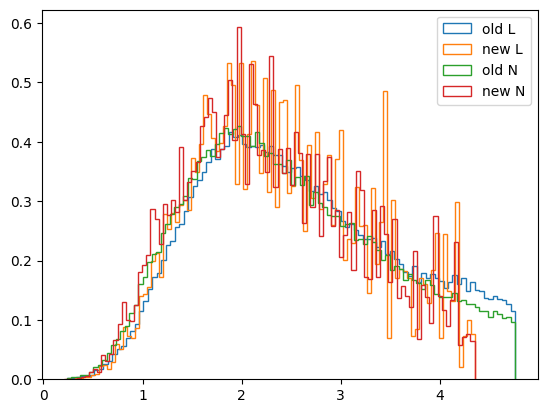

In [46]:
frbs_evolve_with_luminosity = True

z_dist_OLD = get_z_dist_OLD(
    int(1e5),
    -1.39,
    0,
    7.3e4 / u.Gpc**3 / u.year,
    0.96,
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
    frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
)

z_dist_NEW = get_z_dist_NEW(
    int(1e5),
    -1.39,
    0,
    7.3e4 / u.Gpc**3 / u.year,
    0.96,
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
    frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
)

_ = plt.hist(z_dist_OLD, bins=100, density=True, histtype='step', label='old L')
_ = plt.hist(z_dist_NEW, bins=100, density=True, histtype='step', label='new L')
plt.legend()




frbs_evolve_with_luminosity = False

z_dist_OLD = get_z_dist_OLD(
    int(1e5),
    -1.39,
    0,
    7.3e4 / u.Gpc**3 / u.year,
    0.96,
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
    frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
)

z_dist_NEW = get_z_dist_NEW(
    int(1e5),
    -1.39,
    0,
    7.3e4 / u.Gpc**3 / u.year,
    0.96,
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
    frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
)

_ = plt.hist(z_dist_OLD, bins=100, density=True, histtype='step', label='old N')
_ = plt.hist(z_dist_NEW, bins=100, density=True, histtype='step', label='new N')
plt.legend()

78439.64518009193 1 / yr 633.5091078470069 1 / yr


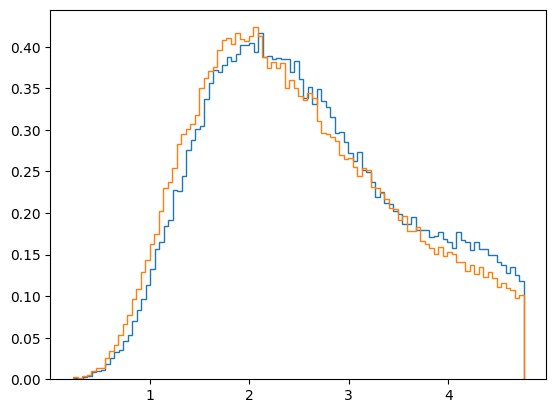

In [19]:
(
    frb_dist_fact_L,
    z_min,
    z_max,
    frb_emission_rate_L,
    frb_z_dist_L
) = get_distribution_dist(
    int(1e4),
    -1.39,
    0,
    7.3e4 / u.Gpc**3 / u.year,
    0.96,
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
    frbs_evolve_with_luminosity = True,
)

(
    frb_dist_fact_N,
    z_min,
    z_max,
    frb_emission_rate_N,
    frb_z_dist_N
) = get_distribution_dist(
    int(1e4),
    -1.39,
    0,
    7.3e4 / u.Gpc**3 / u.year,
    0.96,
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
    frbs_evolve_with_luminosity = False,
)

print(frb_emission_rate_L, frb_emission_rate_N)
_ = plt.hist(frb_z_dist_L, bins=100, density=True, histtype='step', label='old N')
_ = plt.hist(frb_z_dist_N, bins=100, density=True, histtype='step', label='old L')

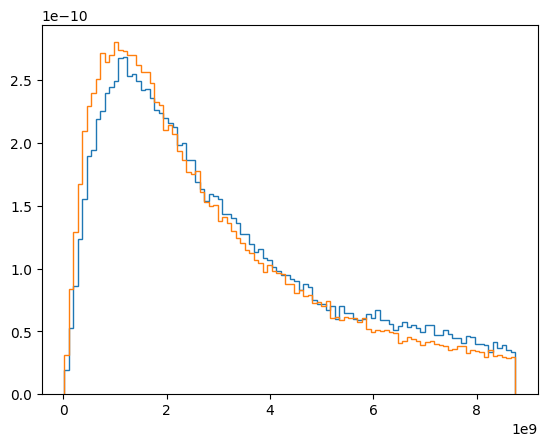

In [17]:
_ = plt.hist(frb_dist_fact_L, bins=100, density=True, histtype='step', label='old N')
_ = plt.hist(frb_dist_fact_N, bins=100, density=True, histtype='step', label='old L')

In [41]:
#lensed_galaxies_z = rng.choice(np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=','), size=lensed_galaxies_z.size)
#lensed_galaxies_Mv = rng.choice(np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=','), size=lensed_galaxies_z.size) * u.M_bol

In [80]:
    number_of_simulated_frbs = int(1e4)
    alpha_spect=-1.39
    alpha_rate=0
    frb_emission_rate_z0_Epivot = 7.3e4 / u.Gpc**3 / u.year
    n_sfr=0.96
    simulate_lensed_frbs = True
    zmin = z_min = lensed_galaxies_z.min()
    zmax = z_max = lensed_galaxies_z.max()
    lensed_fraction = None
    frbs_evolve_with_luminosity = True

In [81]:
    # Unlensed population of galaxies used in Collett 2018 simulations
    z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
    # Ensures that there are ~1000 galaxies per step on average
    z = np.linspace(zmin, zmax, z_org.size//1000+1)
    z_mean = (z[1:] + z[:-1]) / 2

    # Lensed and total galaxies per redshift bin
    Pz_org, _ = np.histogram(z_org, bins=z)

    # Select bins containing enough galaxies
    idx = Pz_org > 10
    Pz_org = Pz_org[idx]
    z_mean = z_mean[idx]
    
    if frbs_evolve_with_luminosity:
        #!!! CHECK THIS
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_sun) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        PL_org = PL_org[idx]
        # Luminosity of lensed galaxies used from Collett 2018 simulations

        # Fraction of luminosity of lensed galaxies per redshift step
        lensed_fraction = 1 / PL_org
    
    else:
        Pz_org = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Fraction of lensed galaxies per redshift step
        lensed_fraction = 1 / Pz_org
    
    # Smooth the output
    lensed_fraction = gf(lensed_fraction, 6)
    # Interpolate with a spline
    cs_org = spline(z_mean, lensed_fraction, extrapolate=False)

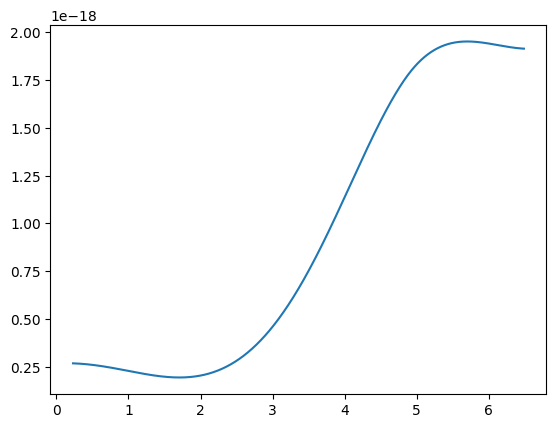

In [82]:
x = np.linspace(z_min, z_max, 1000)
plt.plot(x, cs_org(x))

In [83]:
    lensed_fraction_interp, z_min, z_max = get_lensed_fraction(
        z_min,
        z_max,
        frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
    )
    y_max, z_pdf_norm, frb_emission_rate = set_distribution_redshift(
        z_min,
        z_max,
        alpha_rate,
        frb_emission_rate_z0_Epivot,
        n_sfr
    )

In [84]:
lensed_galaxies_z_inrange = lensed_galaxies_z[(lensed_galaxies_z >= z_min) & (lensed_galaxies_z <= z_max)]

In [76]:
p = z_pdf_norm(lensed_galaxies_z_inrange) * cs(lensed_galaxies_z_inrange)
a = rng.choice(lensed_galaxies_z_inrange, p=p / p.sum(), size=100_000)

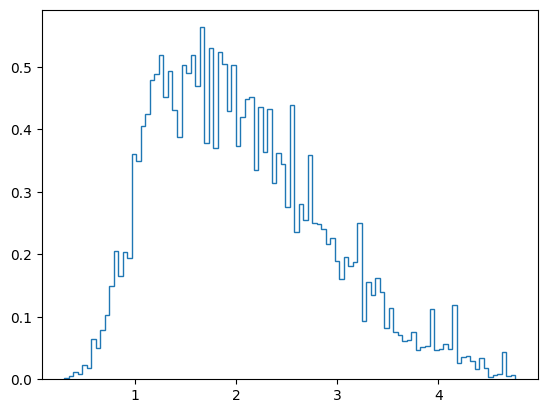

In [77]:
aa,bb = np.histogram(a, bins=100, density=True)
plt.stairs(aa,bb)

In [78]:
        # Only simulate lensed FRBs
        z_dist = np.zeros(number_of_simulated_frbs) + np.nan
        # Maximum fraction of lensed galaxies per redshift
        lensed_fraction_max = lensed_fraction_interp(lensed_fraction_interp.derivative().roots().max())
        # Loop until no nan are present
        while np.isnan(z_dist).any():
            # Redshift distribution of FRBs in lensed galaxies
            z_dist_i = sample_distribution_redshift(
                number_of_simulated_frbs,
                z_min,
                z_max,
                y_max,
                z_pdf_norm,
            )
            # Random values from sample distribution
            y = rng.uniform(low=0, high=lensed_fraction_max, size=number_of_simulated_frbs)
            # Resize the arrays to get the right number of bins
            nan_size = z_dist[np.isnan(z_dist)].size
            z_dist_i = z_dist_i[y < lensed_fraction_interp(z_dist_i)][:nan_size]
            first_nan = np.argmax(z_dist)
            z_dist[first_nan:first_nan+z_dist_i.size] = z_dist_i
        # The FRB emission rate is rescaled to the maximum value used for the random sample distribution,
        # which does not goes up to 1 to save computation time
        frb_emission_rate *= lensed_fraction_max

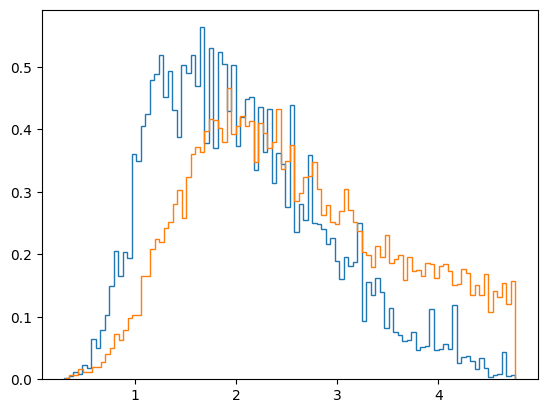

In [79]:
plt.stairs(aa,bb)
cc,dd = np.histogram(z_dist, bins=100, density=True)
plt.stairs(cc,dd)

In [ ]:
    # Unlensed population of galaxies used in Collett 2018 simulations
    z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
    # Ensures that there are ~1000 galaxies per step on average
    z = np.linspace(zmin, zmax, z_org.size//1000+1)
    z_mean = (z[1:] + z[:-1]) / 2

    # Lensed and total galaxies per redshift bin
    Pz_org, _ = np.histogram(z_org, bins=z)

    # Select bins containing enough galaxies
    idx = Pz_org > 10
    Pz_org = Pz_org[idx]
    z_mean = z_mean[idx]
    
    if frbs_evolve_with_luminosity:
        #!!! CHECK THIS
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_sun) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        PL_org = PL_org[idx]
        # Luminosity of lensed galaxies used from Collett 2018 simulations

        # Fraction of luminosity of lensed galaxies per redshift step
        lensed_fraction = 1 / PL_org
    
    else:
        Pz_org = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Fraction of lensed galaxies per redshift step
        lensed_fraction = 1 / Pz_org
    
    # Smooth the output
    lensed_fraction = gf(lensed_fraction, 6)
    # Interpolate with a spline
    cs = spline(z_mean, lensed_fraction, extrapolate=False)

In [86]:
    # Ensures that there are ~1000 galaxies per step on average
    z = np.linspace(zmin, zmax, lensed_galaxies_z.size//1000+1)
    z_mean = (z[1:] + z[:-1]) / 2
    
    # Lensed and total galaxies per redshift bin
    Pz_sim, _ = np.histogram(lensed_galaxies_z, bins=z)

    # Select bins containing enough galaxies
    idx = Pz_sim > 10
    Pz_sim = Pz_sim[idx]
    z_mean = z_mean[idx]
    
    if frbs_evolve_with_luminosity:
        #!!! CHECK THIS
        # Luminosity of lensed galaxies used from Collett 2018 simulations
        L_sim = lensed_galaxies_Mv.to(u.L_sun)
        # Total luminosity of lensed galaxy population per redshift step
        PL_sim, _ = np.histogram(
            lensed_galaxies_z, 
            bins=z, 
            weights=L_sim
        )
        PL_sim = PL_sim[idx]
        # Fraction of luminosity of lensed galaxies per redshift step
        lensed_fraction = PL_sim

    else:
        lensed_fraction = Pz_sim
        
    # Smooth the output
    lensed_fraction = gf(lensed_fraction, 6)
    # Interpolate with a spline
    cs_sim = spline(z_mean, lensed_fraction, extrapolate=False)

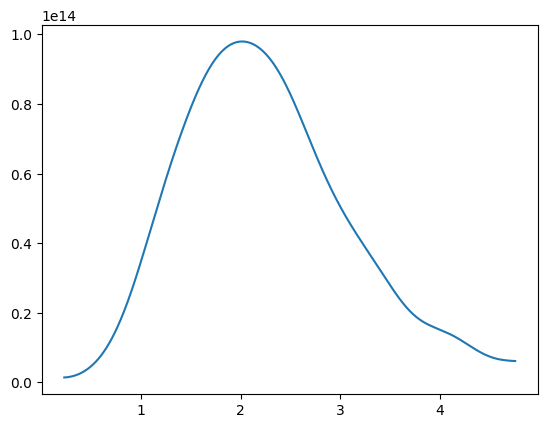

In [87]:
x = np.linspace(z_min, z_max, 1000)
plt.plot(x, cs_sim(x))

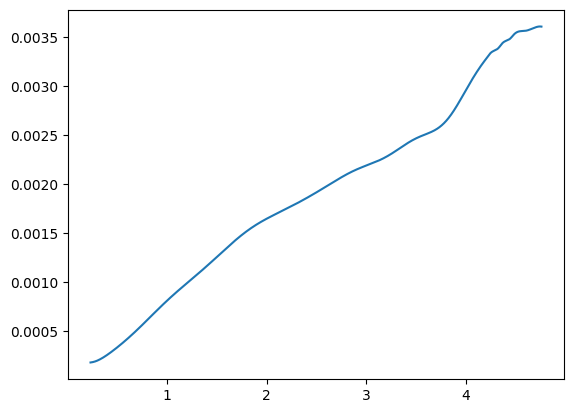

In [92]:
plt.plot(x, cs_sim(x)/cs_org(x))

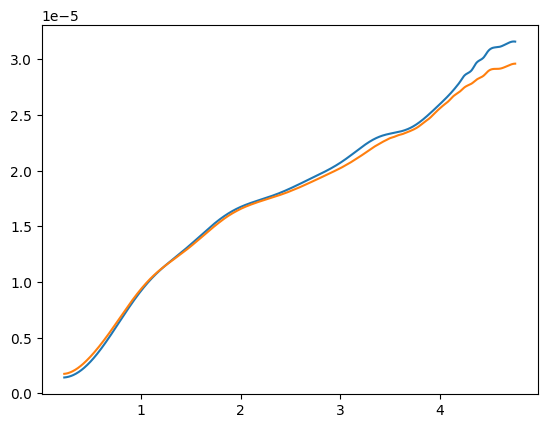

In [185]:
plt.plot(x, cs(x))
plt.plot(x, cs_sim(x)/cs_org(x))

In [214]:
frbs_evolve_with_luminosity = True

In [215]:
    lensed_fraction_interp, z_min, z_max = get_lensed_fraction(
        z_min,
        z_max,
        frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
    )
    y_max, z_pdf_norm, frb_emission_rate = set_distribution_redshift(
        z_min,
        z_max,
        alpha_rate,
        frb_emission_rate_z0_Epivot,
        n_sfr
    )

In [216]:
    # Ensures that there are ~1000 galaxies per step on average
    z = np.linspace(zmin, zmax, lensed_galaxies_z.size//1000+1)
    z_mean = (z[1:] + z[:-1]) / 2
    # Unlensed population of galaxies used in Collett 2018 simulations
    z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
    
    # Lensed and total galaxies per redshift bin
    Pz_sim, _ = np.histogram(lensed_galaxies_z, bins=z)
    Pz_org, _ = np.histogram(z_org, bins=z)

    # Select bins containing enough galaxies
    idx = (Pz_sim > 10) & (Pz_org > 10)
    Pz_sim = Pz_sim[idx]
    Pz_org = Pz_org[idx]
    z_mean = z_mean[idx]
    
    if frbs_evolve_with_luminosity:
        #!!! CHECK THIS
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_sun) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        PL_org = PL_org[idx]
        # Luminosity of lensed galaxies used from Collett 2018 simulations
        L_sim = lensed_galaxies_Mv.to(u.L_sun)
        # Total luminosity of lensed galaxy population per redshift step
        PL_sim, _ = np.histogram(
            lensed_galaxies_z, 
            bins=z, 
            weights=L_sim
        )
        PL_sim = PL_sim[idx]
        # Fraction of luminosity of lensed galaxies per redshift step
        lensed_fraction = PL_sim / PL_org

    else:
        Pz_org = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Fraction of lensed galaxies per redshift step
        lensed_fraction = Pz_sim / Pz_org
        
    # Smooth the output
    lensed_fraction = gf(lensed_fraction, 6)
    # Interpolate with a spline
    cs = spline(z_mean, lensed_fraction, extrapolate=False)

In [217]:
if frbs_evolve_with_luminosity:
    sim = gf(PL_sim, 6)
    org = gf(PL_org, 6)
else:
    sim = gf(Pz_sim, 6)
    org = gf(Pz_org, 6)

cs_sim = spline(z_mean, sim, extrapolate=False)
cs_org = spline(z_mean, org, extrapolate=False)

In [218]:
        # Only simulate lensed FRBs
        z_dist = np.zeros(number_of_simulated_frbs) + np.nan
        # Maximum fraction of lensed galaxies per redshift
        lensed_fraction_max = lensed_fraction_interp(lensed_fraction_interp.derivative().roots().max())
        # Loop until no nan are present
        while np.isnan(z_dist).any():
            # Redshift distribution of FRBs in lensed galaxies
            z_dist_i = sample_distribution_redshift(
                number_of_simulated_frbs,
                z_min,
                z_max,
                y_max,
                z_pdf_norm,
            )
            # Random values from sample distribution
            y = rng.uniform(low=0, high=lensed_fraction_max, size=number_of_simulated_frbs)
            # Resize the arrays to get the right number of bins
            nan_size = z_dist[np.isnan(z_dist)].size
            z_dist_i = z_dist_i[y < lensed_fraction_interp(z_dist_i)][:nan_size]
            first_nan = np.argmax(z_dist)
            z_dist[first_nan:first_nan+z_dist_i.size] = z_dist_i

In [85]:
z_dist_i = sample_distribution_redshift(
    number_of_simulated_frbs,
    z_min,
    z_max,
    y_max,
    z_pdf_norm,
)

In [220]:
p = z_pdf_norm(lensed_galaxies_z_inrange) / cs_org(lensed_galaxies_z_inrange)
frbs_from_lensed_galaxies = rng.choice(lensed_galaxies_z_inrange, p=p / p.sum(), size=100_000)

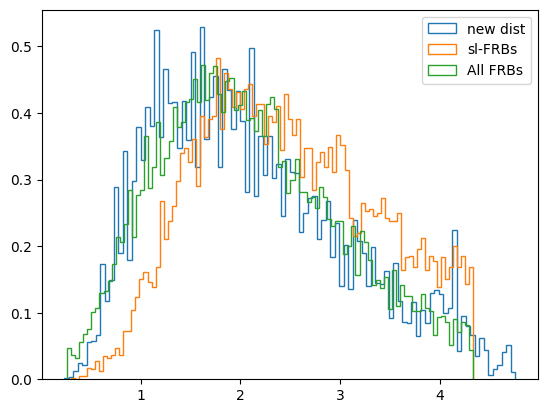

In [221]:
_ = plt.hist(frbs_from_lensed_galaxies, bins=100, density=True, histtype='step', label='new dist')
_ = plt.hist(z_dist, bins=100, density=True, histtype='step', label='sl-FRBs')
_ = plt.hist(z_dist_i, bins=100, density=True, histtype='step', label='All FRBs')
plt.legend()

In [213]:
frbs_from_lensed_galaxies_un = frbs_from_lensed_galaxies.copy()
z_dist_un = z_dist.copy()
z_dist_i_un = z_dist_i.copy()

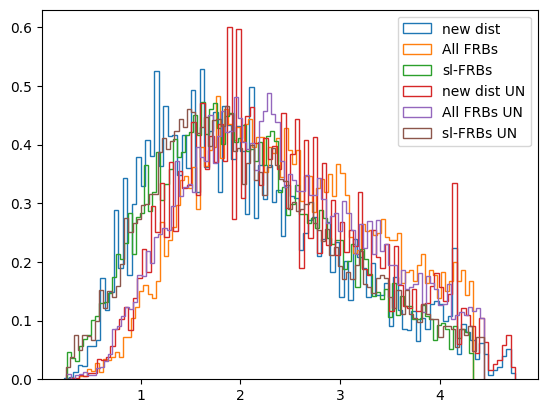

In [222]:
_ = plt.hist(frbs_from_lensed_galaxies, bins=100, density=True, histtype='step', label='new dist')
_ = plt.hist(z_dist, bins=100, density=True, histtype='step', label='All FRBs')
_ = plt.hist(z_dist_i, bins=100, density=True, histtype='step', label='sl-FRBs')
_ = plt.hist(frbs_from_lensed_galaxies_un, bins=100, density=True, histtype='step', label='new dist UN')
_ = plt.hist(z_dist_un, bins=100, density=True, histtype='step', label='All FRBs UN')
_ = plt.hist(z_dist_i_un, bins=100, density=True, histtype='step', label='sl-FRBs UN')
plt.legend()

In [9]:
# Uncertainties
rates = np.zeros(100) / u.yr
for jj in range(rates.size):
    if jj%10 == 0: print(f"Completed {jj * 100 // rates.size}%")
    rates[jj] = frb_detection_rate = run_simulation(
        int(1e3),
        telescope_name='chime',
        simulate_lensed_frbs = False,
        model = 'shin',
        uncertain = True,
        frbs_evolve_with_luminosity = True,
        verbose = False
    )

Completed 0%
Completed 10%
Completed 20%
Completed 30%
Completed 40%
Completed 50%
Completed 60%
Completed 70%
Completed 80%
Completed 90%


In [10]:
rates.min()

<Quantity 0. 1 / yr>

In [13]:
np.median(rates), np.percentile(rates, 16), np.percentile(rates, 84), np.percentile(rates, 84) - np.percentile(rates, 16)

(<Quantity 317.59112173 1 / yr>,
 <Quantity 46.55231809 1 / yr>,
 <Quantity 1326.71033453 1 / yr>,
 <Quantity 1280.15801644 1 / yr>)

In [14]:
rates_valid = rates[rates>0]

In [16]:
np.median(rates_valid), np.percentile(rates_valid, 16), np.percentile(rates_valid, 84), np.percentile(rates_valid, 84) - np.percentile(rates_valid, 16)

(<Quantity 339.63045098 1 / yr>,
 <Quantity 55.59209428 1 / yr>,
 <Quantity 1339.31783126 1 / yr>,
 <Quantity 1283.72573698 1 / yr>)

In [25]:
# Get processing time
%%timeit 
frb_detection_rate = run_simulation(
    int(1e4),
    telescope_name='chime',
    simulate_lensed_frbs = False,
    model = 'shin',
    uncertain = True,
    frbs_evolve_with_luminosity = True,
    verbose=False
)

1.01 s ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
t = [0.19, 1.01, 8.84, ] * u.s
n = [1e3,   1e4,  1e5,  ]

In [49]:
1e5 * (8.84 - 0.19) / (1e5 - 1e3) * 100 / 60

14.56228956228956

In [123]:
# Plot of measured vs simulated rate for different telescopes

# Measured detection rates
telescope_rates = {}

#CHIME (https://arxiv.org/pdf/2106.04352.pdf)
n_frbs = 536
obs_time = 214.8 * 24 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
telescope_rates['CHIME'] = [rate, err]

#FAST (https://iopscience.iop.org/article/10.3847/2041-8213/abe7f0)
n_frbs = 4
obs_time = (1667 + 9) * u.hour
rate = (n_frbs / obs_time).to(1/u.yr) / 9  # 9 to correct for multi-beam receiver
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 9
telescope_rates['FAST'] = [rate, err]

# ASKAP (https://www.nature.com/articles/s41586-018-0588-y)
n_frbs = 20
obs_time = 32_840 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
telescope_rates['ASKAP'] = [rate, err]

# Aperitif (https://arxiv.org/pdf/2205.12362.pdf)
n_frbs = 5
obs_time = 800 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr) / 40  # 40 to correct for compound beams
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 40
telescope_rates['Aperitif'] = [rate, err]

# UTMOST (https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.2989F/abstract)
n_frbs = 6
obs_time = (344 * u.day).to(u.hour)
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
telescope_rates['UTMOST'] = [rate, err]

# Parkes (https://arxiv.org/pdf/1511.07746.pdf)
n_frbs = 9
obs_time = (33_500 * 270 * u.s).to(u.hour)
rate = (n_frbs / obs_time).to(1/u.yr) / 13  # 13 to correct for multi-beam receiver
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 13
telescope_rates['Parkes'] = [rate, err]

# CHORD (https://ui.adsabs.harvard.edu/abs/2019clrp.2020...28V/abstract)
telescope_rates['CHORD'] = [25.5 * 365 / u.yr, 7 * 365 / u.yr]

# DSA2000 (https://ui.adsabs.harvard.edu/abs/2019BAAS...51g.255H/abstract)
telescope_rates['DSA2000'] = [1e4 / u.yr, 5e3 / u.yr]

telescope_list = sorted(telescope_rates.keys(), key=lambda v: v.upper())

In [161]:
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility
number_of_simulated_frbs = int(1e5)  # Elements in the simulation
observing_time = 1  # Fraction of observing time

shin_values = []
shin_uncert_up = []
shin_uncert_down = []
med = []
for t in telescope_list:
    print(t)
    telescope = t.lower()
    # Shin model
    value = run_simulation(
            number_of_simulated_frbs,
            telescope_name = telescope,
            simulate_lensed_frbs = False,
            model = 'shin',
            uncertain = False,
            verbose = False,
        ).to(1/u.yr).value
    uncert = np.array([
        run_simulation(
            number_of_simulated_frbs // 100,
            telescope_name = telescope,
            simulate_lensed_frbs = False,
            model = 'shin',
            uncertain = True,
            verbose = False
        ).to(1/u.yr).value for n in range(100)
    ])
    shin_values.append(value)
    shin_uncert_down.append(np.percentile(uncert[uncert>0], 16))
    shin_uncert_up.append(np.percentile(uncert[uncert>0], 84))
    med.append(np.median(uncert[uncert>0]))
    
shin_values = np.array(shin_values) / u.yr
shin_uncert_down = np.array(shin_uncert_down) / u.yr
shin_uncert_up = np.array(shin_uncert_up) / u.yr

Aperitif
ASKAP
CHIME
CHORD
DSA2000
FAST
Parkes
UTMOST


Text(0, 0.5, 'Rate (1/yr)')

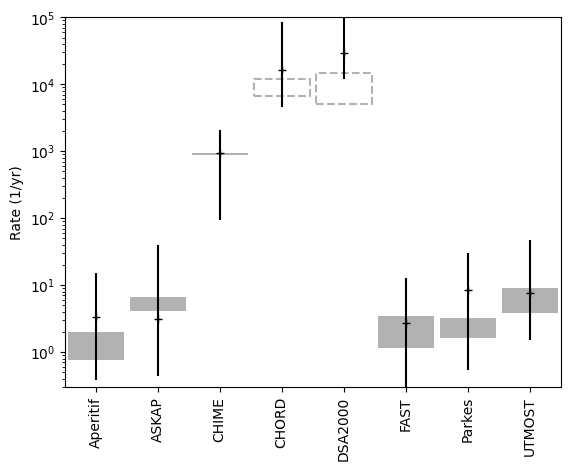

In [171]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()

x = np.arange(len(telescope_list))
ax.errorbar(
    x,
    shin_values,
    yerr=(shin_values-shin_uncert_down, shin_uncert_up-shin_values),
    fmt='k+',
    label='Shin+ 2023',
    zorder=5
)
#ax.errorbar(x, shin_values_r, yerr=shin_uncert_r, fmt='r+', label='(rate interpretation)', zorder=5)
#ax.errorbar(x+0.1, james_values, yerr=james_uncert, fmt='g+', label='James+ 2023', zorder=5)

#ax.plot(x-0.1, shin_values, 'k+', label='Shin+ 2023', zorder=5)
#ax.plot(x, shin_values_r, 'r+', label='(rate interpretation)', zorder=5)
#ax.plot(x+0.1, james_values, 'g+', label='James+ 2023', zorder=5)
#ax.plot(x, med, 'r+', zorder=6)


for telescope, xi in zip(telescope_list, x):
    rate = telescope_rates[telescope]
    if telescope.lower() in ['chord', 'dsa2000']:
        rect = Rectangle(
            (xi - 0.45, (rate[0] - rate[1]).to(1/u.yr).value),
            0.9,
            rate[1].to(1/u.yr).value * 2,
            alpha=0.3,
            color='k',
            fc='none',
            hatch = hatch,
            ls = '--',
            lw = 1.5
        )
    else:
        rect = Rectangle(
            (xi - 0.45, (rate[0] - rate[1]).to(1/u.yr).value),
            0.9,
            rate[1].to(1/u.yr).value * 2,
            alpha=0.3,
            color='k',
            ec='none',
            hatch = hatch
        )
    ax.add_patch(rect)

#ax.legend()
ax.set_yscale('log')
ax.set_xlim(x.min()-0.5, x.max()+0.5)
ax.set_ylim(0.3, 100_000)
ax.set_xticks(x)
ax.set_xticklabels(telescope_list, rotation='vertical')
ax.set_ylabel("Rate (1/yr)")

In [135]:
    uncert = np.array([
        run_simulation(
            int(1e3),
            telescope_name = 'chime',
            simulate_lensed_frbs = False,
            model = 'shin',
            uncertain = True,
            verbose = False
        ).to(1/u.yr).value for n in range(100)
    ])

In [138]:
a = uncert[uncert>0]

In [142]:
v = np.median(a)
err_d = np.percentile(uncert, 16)
err_u = np.percentile(uncert, 84)

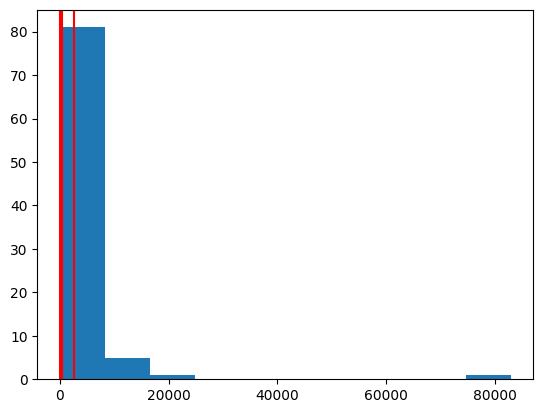

In [144]:
_ = plt.hist(a)

plt.axvline(v, color='r')
plt.axvline(err_d, color='r')
plt.axvline(err_u, color='r')

In [150]:
d = v-err_d
u = v+err_u

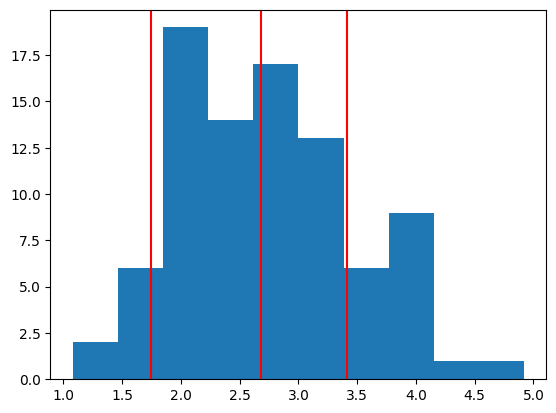

In [151]:
_ = plt.hist(np.log10(a))
plt.axvline(np.log10(v), color='r')
plt.axvline(np.log10(v-d), color='r')
plt.axvline(np.log10(u-v), color='r')

In [44]:
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility
number_of_simulated_frbs = int(1e5)  # Elements in the simulation
observing_time = 1  # Fraction of observing time

shin_values = []
shin_uncert_up = []
shin_uncert_down = []
t = 'Aperitif'

telescope = t.lower()
# Shin model
value = (
    run_simulation(
        number_of_simulated_frbs,
        telescope_name = telescope,
        simulate_lensed_frbs = False,
        model = 'shin',
        uncertain = False,
        verbose = False,
    ).to(1/u.yr).value
)
uncert = np.array([
    run_simulation(
        number_of_simulated_frbs // 100,
        telescope_name = telescope,
        simulate_lensed_frbs = False,
        model = 'shin',
        uncertain = True,
        verbose = False
    ).to(1/u.yr).value for n in range(100)
])

In [39]:
value, np.median(uncert)

(0.6799533248269528, 1.8112346117264617)

In [37]:
np.percentile(uncert, 16), np.percentile(uncert, 84)

(0.14678159507329985, 18.43477844199884)

In [40]:
telescope_list

['Aperitif', 'ASKAP', 'CHIME', 'FAST', 'Parkes', 'UTMOST']

In [327]:
(10**1.96/u.Mpc**3/u.yr).to(1/u.Gpc**3/u.yr)

<Quantity 9.12010839e+10 1 / (Gpc3 yr)>

In [343]:
gamma = -0.95+0.18
Echar = 10**41.26
(10**1.96/u.Mpc**3/u.yr).to(1/u.Gpc**3/u.yr) * (
    float(gammainc(gamma, (1e39*u.erg / Echar).value)) / 
    float(gammainc(gamma, (1e30*u.erg / Echar).value))
)

<Quantity 10140.48186066 1 / (Gpc3 yr)>

In [8]:
(
    float(gammainc(gamma + 1, (1e39*u.erg / Echar).value)) / 
    float(gammainc(gamma + 1, (1e30*u.erg / Echar).value))
)

0.2897268536490609

In [344]:
9e4

90000.0

In [ ]:
# Follow-up
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time

In [4]:
source_low_dec = SkyCoord(ra=0*u.deg, dec=-10*u.deg)
source_mid_dec = SkyCoord(ra=0*u.deg, dec=45*u.deg)
source_high_dec = SkyCoord(ra=0*u.deg, dec=89*u.deg)

In [5]:
gbt = EarthLocation.of_site('GBT')
gmrt = EarthLocation.of_site('GMRT')
eff = EarthLocation.of_site('Effelsberg')

90.0% of time the source can be observed


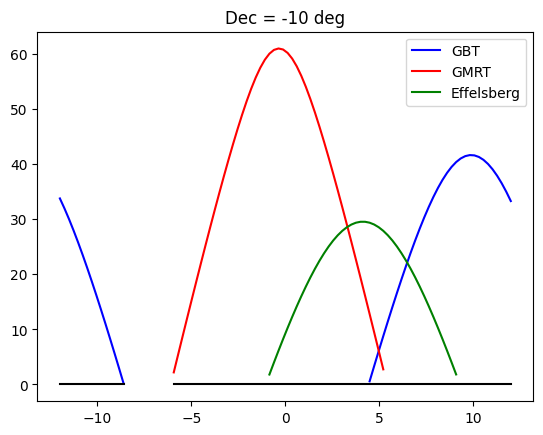

In [26]:
# Low dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_low_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_low_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_low_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = -10 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

100.0% of time the source can be observed


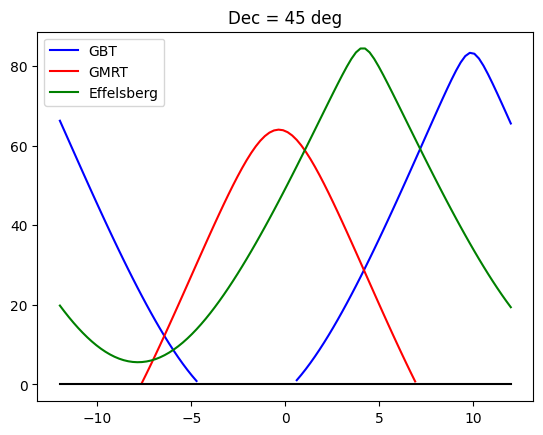

In [27]:
# Mid dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_mid_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_mid_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_mid_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = 45 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

100.0% of time the source can be observed


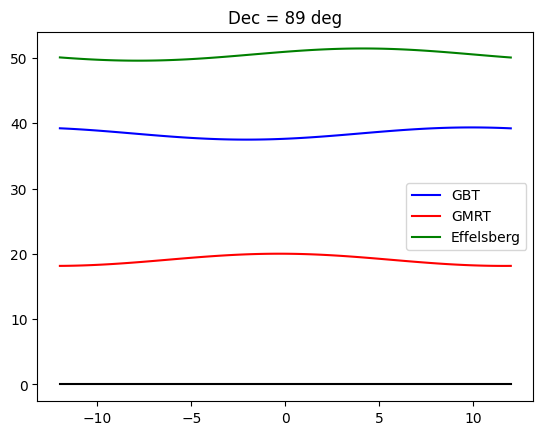

In [28]:
# High dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_high_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_high_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_high_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = 89 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

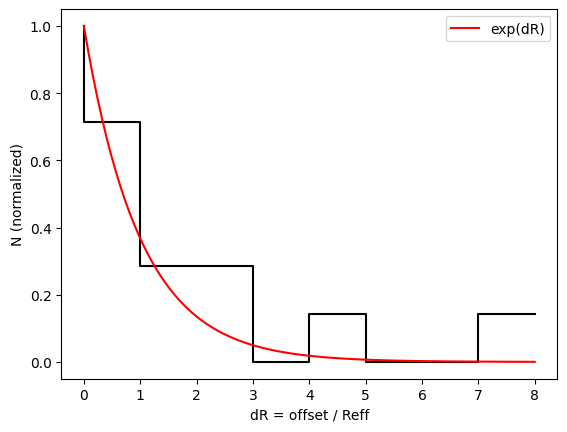

In [1125]:
# FRB radial distribution within host galaxies

#https://arxiv.org/pdf/2009.10747.pdf
#https://arxiv.org/pdf/2302.14782.pdf
#https://arxiv.org/pdf/2108.01282.pdf
#https://arxiv.org/pdf/2301.01000.pdf

# i-band and r-band
offset = np.array([0.6, 5.5, 3.4, 1.2, 2.0, 27, 6.6, 11, 3.2, 1.9, 11, 3.0, 9.87, 3.80, 10.8, 5.7, 5.9, 2.3])
reff = np.array([0.7, 3.6, 2.7, 7.2, 4.4, 3.3, 2.8, 2.1, 2.9, 3.9, 5.5, 1.6, 2.67, 6.64, 5.80, 1.78, 7.58, 2.7])

r = np.sort(offset / reff)
F = np.arange(r.size)/r.size

from scipy import stats
y_hist, bins = np.histogram(r, bins=np.arange(10))
x_hist = bins[:-1]
plt.step(x_hist, y_hist/y_hist.max(), color='k')


x = np.linspace(x_hist.min(), x_hist.max(), 100)
y = np.exp(-x)
#y = y / y.max() * 7
plt.plot(x, y, 'r-', label='exp(dR)')
plt.xlabel('dR = offset / Reff')
plt.ylabel('N (normalized)')
plt.legend()

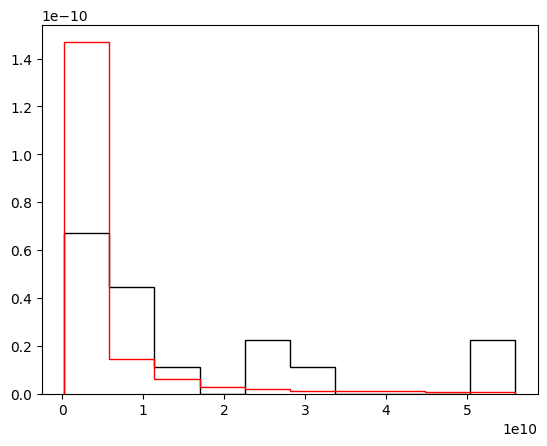

In [167]:
# Host luminosity distribution
mag = np.array([-16.20, -19.46, -20.81, -20.40, -19.85, -22.06, -21.22, -19.01, -19.92, -22.13, -18.05, -18.80, -21.38, -20.18, -18.26, -21.49]) * u.M_bol
y_hist, bins = np.histogram(mag.to(u.L_sun).value, bins=10, density=True)
plt.stairs(y_hist, bins, color='k')

M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
M_org = M_org[z_org<1]
y_hist_org, bins = np.histogram(M_org.to(u.L_sun).value, bins=bins, density=True)
plt.stairs(y_hist_org, bins, color='r')

([], [])

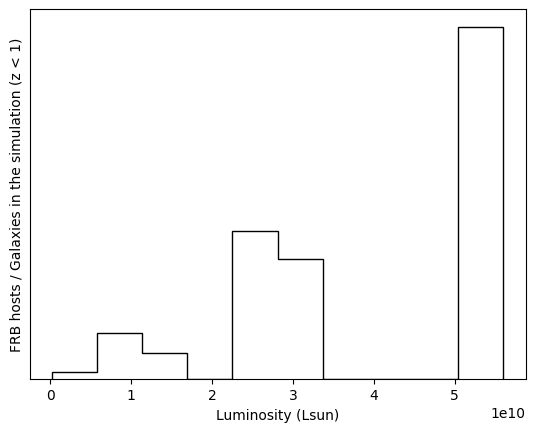

In [169]:
plt.stairs(y_hist / y_hist_org, bins, color='k')
plt.xlabel('Luminosity (Lsun)')
plt.ylabel('FRB hosts / Galaxies in the simulation (z < 1)')
plt.yticks([])

([], [])

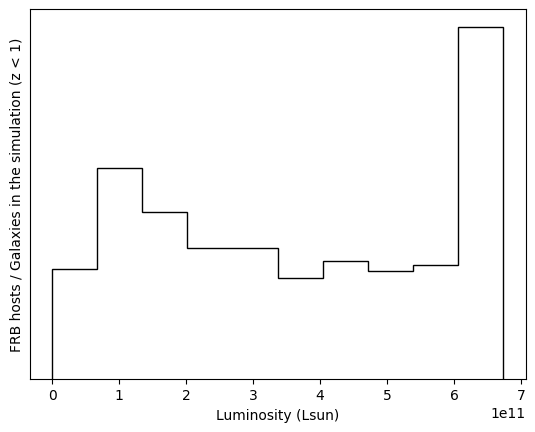

In [171]:
M_sim = np.loadtxt('lenses_Euclid.txt', usecols=15, skiprows=1) * u.M_bol # Magnitude distribution
z_sim = np.loadtxt('lenses_Euclid.txt', usecols=1, skiprows=1)  # Redshift distribution
y_hist_sim, bins = np.histogram(M_sim.to(u.L_sun).value, density=True)

M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
y_hist_org, bins = np.histogram(M_org.to(u.L_sun).value, bins=bins, density=True)

plt.stairs(y_hist_sim / y_hist_org, bins, color='k')
plt.xlabel('Luminosity (Lsun)')
plt.ylabel('FRB hosts / Galaxies in the simulation (z < 1)')
plt.yticks([])

In [18]:
# Shin+23 Fig.1

with open('emcee_sampler_output.p', "rb") as input_file:
    sampler = pickle.load(input_file)
samples = sampler.get_chain(flat=True, thin=20)
samples[:,0] = (samples[:,0]+np.log(rate_corr_factor))*np.log10(np.e)
samples[:,2] = samples[:,2]*np.log10(np.e)
samples[:,5] = samples[:,5]*np.log10(np.e)
samples[:,6] = samples[:,6]*np.log10(np.e)


# making corner plot
fig = corner.corner(
    samples
)

NameError: name 'corner' is not defined

In [208]:
m.min(), m.max()

(<Quantity 3.41157474e+09 solMass>, <Quantity 8.78159517e+11 solMass>)

In [1]:
# Create galaxy csv
import pandas as pd
import numpy as np
from numpy.random import default_rng

seed = 2911167007  # Seed of random processes
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility

# Tom's simulations
euclid_sim = pd.read_csv('lenses_Euclid.txt', delim_whitespace=True)

# Ana's simulations
dfs = list()
for ii in np.arange(0.01, 1, 0.01):
    jj = round(ii, 2)
    tab = pd.read_csv(f"SIE/positions_mu_t_q={jj}.csv", index_col=0)
    tab["q"] = jj
    dfs.append(tab)
magnification_sim = pd.concat(dfs, ignore_index=True)

# Distance between the lens and the fast radio burst
dist_lens_host = np.sqrt(euclid_sim['x_s_unlensed']**2 + euclid_sim['y_s_unlensed']**2)
dist_host_frb = rng.exponential(1) * euclid_sim['halflightradius_s(arcsec)']
dist_lens_frb = dist_lens_host + dist_host_frb * np.cos(rng.uniform(low=0, high=2*np.pi))

# Clip ellipticity to match Ana's simulations
euclid_sim['q_l'] = np.clip(euclid_sim['q_l'], 0.01, 0.99)

# For each source galaxy, select the backround source closest to the FRB position
rand_index = []
for q, d in zip(euclid_sim['q_l'], dist_lens_frb):
    rand_index.append(
        (
            magnification_sim['weights'][np.isclose(magnification_sim['q'], q)] - d
        ).abs().idxmin()
    )
    
# Table with all images for each host galaxy
total_table = pd.concat([euclid_sim, magnification_sim.iloc[rand_index].reset_index()], axis=1)

In [3]:
total_table.iloc[11]

z_l                               0.960000
z_s                               3.600000
R_Ein(arcsec)                     0.460000
sigma(km/s)                     173.350000
q_l                               0.670000
halflightradius_l(arcsec)         0.360000
mag_l_VIS                        23.610000
x_s_unlensed                      0.170000
y_s_unlensed                      0.180000
q_s                               0.700000
pa_s(degrees)                   138.100000
halflightradius_s(arcsec)         0.130000
mag_s_VIS                        24.740000
averagemagnification              3.650000
SNRofSource                      46.250000
M_absolute_source_r             -21.330000
index                        283340.000000
RA                                0.278043
DEC                              -0.601967
N_images                          2.000000
mu_tot                            2.645720
tmax                             38.677139
im1_RA                            0.540745
im1_DEC    

In [5]:
# https://www.imprs-astro.mpg.de/sites/default/files/lyskova.pdf

from astropy import units as u
from astropy.coordinates import Distance
from astropy import constants as const
from astropy.cosmology import Planck18 as cosmo

m = (
    1.6 * 
    (np.array(euclid_sim['sigma(km/s)'])*u.km/u.s)**2 *
    (np.array(euclid_sim['halflightradius_l(arcsec)'])*u.arcsec).to(u.rad).value *
    cosmo.angular_diameter_distance(np.array(euclid_sim['z_l'])) / 
    const.G
).to(u.M_sun)

In [6]:
a = pd.DataFrame()
a['impact_parameter'] = dist_lens_frb / euclid_sim['halflightradius_l(arcsec)']
a['lens_mass'] = m.value
a['sigma(km/s)'] = euclid_sim['sigma(km/s)']
a['halflightradius_l(arcsec)'] = euclid_sim['halflightradius_l(arcsec)']

In [9]:
a.to_csv('b_mass.csv', sep=' ', index=False)

In [14]:
a['impact_parameter'].max()

11.32378210982464

In [18]:
# Clip ellipticity to match Ana's simulations
euclid_sim['q_l'] = np.clip(euclid_sim['q_l'], 0.01, 0.99)

In [19]:
# Distance between the lens and the fast radio burst
dist_lens_host = np.sqrt(euclid_sim['x_s_unlensed']**2 + euclid_sim['y_s_unlensed']**2)
dist_host_frb = rng.exponential(1) * euclid_sim['halflightradius_s(arcsec)']
dist_lens_frb = dist_lens_host + dist_host_frb * np.cos(rng.uniform(low=0, high=2*np.pi))

In [20]:
dist_lens_frb_Er = dist_lens_frb / euclid_sim['R_Ein(arcsec)']

In [1]:
dist_lens_host

NameError: name 'dist_lens_host' is not defined

In [28]:
tom_sim = euclid_sim.iloc[0]
ana_sim = magnification_sim

frb_host_dist = rng.exponential(1) * tom_sim['halflightradius_s(arcsec)'] * u.arcsec
frb_host_angle = rng.uniform(low=0, high=2*np.pi) * u.rad
frb_host_x = frb_host_dist * np.cos(frb_host_angle)
frb_host_y = frb_host_dist * np.sin(frb_host_angle)
frb_lens_x = frb_host_x + tom_sim['x_s_unlensed'] * u.arcsec
frb_lens_y = frb_host_y + tom_sim['y_s_unlensed'] * u.arcsec

frb_lens_x_Er = frb_lens_x / tom_sim['R_Ein(arcsec)'] / u.arcsec
frb_lens_y_Er = frb_lens_y / tom_sim['R_Ein(arcsec)'] / u.arcsec

ana_sample = ana_sim[np.isclose(ana_sim['q'], tom_sim['q_l'])]
dist = np.sqrt((ana_sample['RA'] - frb_lens_x_Er)**2 + (ana_sample['DEC'] - frb_lens_y_Er)**2)
images = ana_sample.iloc[dist.argmin()]

position_RA = images['im1_RA'] * tom_sim['R_Ein(arcsec)'] * u.arcsec
position_DEC = images['im1_DEC'] * tom_sim['R_Ein(arcsec)'] * u.arcsec

In [ ]:
import pandas as pd

In [8]:
euclid_sim = pd.read_csv('lenses_Euclid.txt', delim_whitespace=True)

In [9]:
dist_lens_host = np.sqrt(euclid_sim['x_s_unlensed']**2 + euclid_sim['y_s_unlensed']**2)

In [15]:
(
    (np.array(dist_lens_host) * u.arcsec).to(u.rad) * 
    cosmo.angular_diameter_distance(np.array(euclid_sim['z_l']))
).to(u.kpc, equivalencies=u.dimensionless_angles())

<Quantity [2.34553033, 0.87198583, 0.73381534, ..., 1.2557369 , 1.41339675,
           1.85286709] kpc>

In [3]:
# Create galaxy csv
import pandas as pd
import numpy as np
from numpy.random import default_rng

seed = 2911167007  # Seed of random processes
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility

# Tom's simulations
euclid_sim = pd.read_csv(
    'lenses_Euclid.txt',
    delim_whitespace=True,
    usecols = [
        'z_l', 'z_s', 'R_Ein(arcsec)', 'sigma(km/s)', 'q_l',
        'halflightradius_l(arcsec)', 'x_s_unlensed', 'y_s_unlensed', 
        'halflightradius_s(arcsec)', 'M_absolute_source_r'
    ]
)
euclid_sim['q_l'] = np.clip(euclid_sim['q_l'], 0.01, 0.99)

# Ana's simulations
dfs = list()
for jj in euclid_sim['q_l'].unique():
    tab = pd.read_csv(
        f"SIE/positions_mu_t_q={jj}.csv",
        index_col=0,
        usecols=[
            'RA', 'DEC', 'N_images', 'im1_RA', 'im1_DEC', 'mu_1',
            't1', 'im2_RA', 'im2_DEC', 'mu_2', 't2', 'im3_RA', 'im3_DEC',
            'mu_3', 't3', 'im4_RA', 'im4_DEC', 'mu_4', 't4', 'weights'
        ]
    )
    tab["q"] = jj
    dfs.append(tab)
magnification_sim = pd.concat(dfs, ignore_index=True)

In [412]:
frb_host_dist = rng.exponential(1) * euclid_sim['halflightradius_s(arcsec)'] * u.arcsec
frb_host_angle = rng.uniform(low=0, high=2*np.pi) * u.rad
frb_host_x = frb_host_dist * np.cos(frb_host_angle)
frb_host_y = frb_host_dist * np.sin(frb_host_angle)
frb_lens_x = frb_host_x + euclid_sim['x_s_unlensed'] * u.arcsec
frb_lens_y = frb_host_y + euclid_sim['y_s_unlensed'] * u.arcsec
frb_lens_x_Er = frb_lens_x / euclid_sim['R_Ein(arcsec)'] / u.arcsec
frb_lens_y_Er = frb_lens_y / euclid_sim['R_Ein(arcsec)'] / u.arcsec

In [ ]:
merged_table = euclid_sim[['q_l']].merge(magnification_sim[['q']], left_on='q_l', right_on='q', how='left')

In [ ]:
merged_table.info

NameError: name 'merged_table' is not defined

In [4]:
magnification_sim

,DEC,N_images,im1_RA,im1_DEC,mu_1,t1,im2_RA,im2_DEC,mu_2,t2,im3_RA,im3_DEC,mu_3,t3,im4_RA,im4_DEC,mu_4,t4,weights,q
0,0.407586,2,-0.980307,1.201367,2.766235,0,0.318977,-0.319640,0.826130,30.805729,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.548814,0.92
1,0.683409,2,-0.475575,1.659552,2.266911,0,0.093587,-0.280438,0.440603,40.501054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.715189,0.92
2,0.251835,2,1.421821,0.719956,2.796366,0,-0.357207,-0.149990,0.604160,33.458033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.602763,0.92
3,0.435678,2,-0.871084,1.280880,2.738381,0,0.292956,-0.352003,0.859463,30.656528,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.544883,0.92
4,0.421007,2,0.142354,1.429651,3.013072,0,-0.075278,-0.584497,1.588280,24.036522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.423655,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371891,-0.690045,2,0.166294,0.294664,1.968006,0,-0.084883,-1.735858,1.347008,-40.683703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.692918,0.20
371892,-0.067996,4,-0.376663,0.945462,1.892207,0,-0.343240,-1.093345,1.689859,-3.884289,-0.829688,0.040802,0.618384,4.840269,0.416202,0.015672,0.233656,12.072476,0.218156,0.20
371893,0.141783,4,-0.366426,-0.867953,2.055205,0,-0.299710,1.174022,1.614022,-8.127759,-0.801245,-0.085210,0.683038,3.337036,0.429998,-0.034958,0.261959,9.821036,0.235453,0.20
371894,-0.197111,4,0.022073,0.849085,2.112796,0,0.016318,-1.243420,1.561678,-11.549199,0.617325,0.083029,0.498568,4.668355,-0.596968,0.078963,0.470757,5.023652,0.197388,0.20


In [ ]:
tom_sim = euclid_sim.iloc[0]
ana_sim = magnification_sim

frb_host_dist = rng.exponential(1) * tom_sim['halflightradius_s(arcsec)'] * u.arcsec
frb_host_angle = rng.uniform(low=0, high=2*np.pi) * u.rad
frb_host_x = frb_host_dist * np.cos(frb_host_angle)
frb_host_y = frb_host_dist * np.sin(frb_host_angle)
frb_lens_x = frb_host_x + tom_sim['x_s_unlensed'] * u.arcsec
frb_lens_y = frb_host_y + tom_sim['y_s_unlensed'] * u.arcsec

frb_lens_x_Er = frb_lens_x / tom_sim['R_Ein(arcsec)'] / u.arcsec
frb_lens_y_Er = frb_lens_y / tom_sim['R_Ein(arcsec)'] / u.arcsec

ana_sample = ana_sim[np.isclose(ana_sim['q'], tom_sim['q_l'])]
dist = np.sqrt((ana_sample['RA'] - frb_lens_x_Er)**2 + (ana_sample['DEC'] - frb_lens_y_Er)**2)
images = ana_sample.iloc[dist.argmin()]

position_RA = images['im1_RA'] * tom_sim['R_Ein(arcsec)'] * u.arcsec
position_DEC = images['im1_DEC'] * tom_sim['R_Ein(arcsec)'] * u.arcsec

In [391]:
a = euclid_sim[['z_l', 'q_l']]
a = a[a['q_l'] <= 0.22].iloc[:10]
b = magnification_sim[['RA', 'DEC', 'q']]
b = b[(b['q'] >= 0.2) & (b['q'] <= 0.22)]

In [396]:
a.shape, b.shape

((10, 2), (15, 3))

In [395]:
a.merge(b, left_on='q_l', right_on='q', how='left')

,z_l,q_l,RA,DEC,q
0,0.43,0.22,-0.367519,0.407586,0.22
1,0.43,0.22,-0.210828,0.683409,0.22
2,0.43,0.22,0.547634,0.251835,0.22
3,0.43,0.22,-0.327234,0.435678,0.22
4,0.43,0.22,0.047294,0.421007,0.22
5,1.04,0.22,-0.367519,0.407586,0.22
6,1.04,0.22,-0.210828,0.683409,0.22
7,1.04,0.22,0.547634,0.251835,0.22
8,1.04,0.22,-0.327234,0.435678,0.22
9,1.04,0.22,0.047294,0.421007,0.22


In [377]:
df1 = pd.DataFrame({'lkey': ['foo', 'bar', 'baz', 'foo'],
                    'value': [1, 2, 3, 5]})
df2 = pd.DataFrame({'rkey': ['foo', 'bar', 'baz', 'foo'],
                    'value': [5, 6, 7, 8]})

In [9]:
dfs = list()
for ii in np.arange(0.01, 1, 0.01):
    jj = round(ii, 2)
    tab = pd.read_csv(f"SIE/positions_mu_t_q={jj}.csv", index_col=0)
    tab["q"] = jj
    dfs.append(tab)
magnification_sim = pd.concat(dfs, ignore_index=True)

In [13]:
magnification_sim.to_csv(
    'SIE.csv',
    float_format="%.4f"
)

In [10]:
magnification_sim

,RA,DEC,N_images,mu_tot,tmax,im1_RA,im1_DEC,mu_1,t1,im2_RA,...,im3_RA,im3_DEC,mu_3,t3,im4_RA,im4_DEC,mu_4,t4,weights,q
0,0.047294,0.421007,2,1.593690,12.618986,0.052737,0.950345,1.119718,0,-0.061422,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.423655,0.01
1,-0.090746,0.372549,2,1.238111,11.498823,-0.101796,0.901450,1.124435,0,0.043195,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.383442,0.01
2,-0.029792,0.064487,4,2.514491,4.732530,-0.037754,-0.464692,1.273810,0,-0.035686,...,-0.185652,-0.001312,0.023261,2.560078,0.126069,-0.000884,0.015639,2.820116,0.071036,0.01
3,-0.072908,-0.047707,4,2.508205,4.659306,-0.091427,0.480142,1.261966,0,-0.087775,...,-0.228869,0.001164,0.026351,2.611526,0.083067,0.000415,0.009374,3.248286,0.087129,0.01
4,-0.001286,-0.020177,4,2.500453,3.894625,-0.001594,0.509300,1.244317,0,-0.001566,...,-0.157348,0.000325,0.016329,3.284669,0.154775,0.000319,0.016058,3.295912,0.020218,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443228,-0.207288,-0.067996,2,9.207748,12.200882,-1.152598,-0.390054,5.717609,0,0.743735,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.218156,0.99
443229,-0.187978,0.141783,2,8.500649,13.180731,-0.975640,0.757216,5.282616,0,0.616192,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.235453,0.99
443230,0.010450,-0.197111,2,10.093124,11.072287,0.061404,-1.197473,5.876722,0,-0.044064,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.197388,0.99
443231,0.394242,0.059367,2,5.041787,22.291050,1.380976,0.211516,3.561471,0,-0.593234,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.398687,0.99
